### Essential Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FixedLocator

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import ipywidgets as widgets
from ipywidgets import interactive
from IPython.display import display, Latex

from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from DNN import Regressor

import os
import re
import time
from zipfile import ZipFile

# Orthogonal Legendre and Hermite polynomials
from numpy import polynomial as P
from scipy import special
from scipy.special import legendre, hermite
from scipy.special import eval_legendre
from scipy.spatial import ConvexHull,QhullError
from matplotlib.tri import Triangulation, LinearTriInterpolator
from scipy.interpolate import griddata


import warnings
# Disable all warnings
warnings.filterwarnings("ignore")

from matplotlib import rc
rc('mathtext', fontset='cm')

### Global variables

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    torch.cuda.set_device(device)


selected_columns = ['cos(theta)', 'R_surf', 'dR_dtheta', 'g_surf', 'Rpole_num', 'Req_num', 
                    'Rpol/Req', 'ellipticity', 'eccentricity', 'rho_c', 'r_ratio', 'M', 'M(km)',
                    'Req', 'C', 'K', 'g_0(km^(-1))', 'Ibar', 'f(Hz)', 'f_tilde', 'Jgeom(km^2)',
                    'x', 'sigma', 'T/W', 'Mxf_tilde', 'Rxf_tilde', 'Qbar', 'S3bar', 'EoS']

selected_features = ['|cos(theta)|', 'C', 'sigma', 'eccentricity']

abs_mu_min, abs_mu_max = 0., 1. 
C_min, C_max = 0.0876346858172578, 0.3094541325480277
sigma_min, sigma_max = 0., 0.9612274013913829
eccentricity_min, eccentricity_max = 0., 0.7797886226038347

min_values = np.array([abs_mu_min, C_min, sigma_min, eccentricity_min])
max_values = np.array([abs_mu_max, C_max, sigma_max, eccentricity_max])
feature_scaler = lambda data: (data - min_values) / (max_values - min_values)

N_MU = 521

#### Read Star Data

In [3]:
def read_zip(file_name, spin, test_percentage=0.2):
    # random seed for 'freezing' randomness
    SEED = 42
    rng = np.random.default_rng(SEED)
    
    # specifying the zip file name
    columns_names = ['cos(theta)', 'R_surf', 'dR_dtheta', 'g_surf', 'Rpole_num', 'Req_num', 'Rpol/Req',
                    'ellipticity', 'eccentricity', 'P_c', 'rho_c', 'r_ratio', 'r_e', 'M', 'M(km)',
                    'Req', 'C', 'K', 'g_0(km^(-1))', 'I(kgkm^2)', 'I(km^3)', 'Ibar', 'Z_p', 'Z_b',
                    'Z_f', 'Ω(Hz)', 'f(Hz)', 'f_tilde', 'Jgeom(km^2)', 'x', 'sigma', 'T/W',
                    'Mxf_tilde', 'Rxf_tilde', 'conv_rad', 'conv_plus', 'conv_minus', 'h_plus',
                    'h_minus', 'r_plus', 'r_minus', 'Q(km^3)', 'Qbar', 'S3(km^4)', 'S3bar', 'M4_geom',
                    'M4_asy^GH_geom', 'M4_asy_geom', 'M4_geom_2points', 'M4_geom_3points',
                    'M4_geom_4points', 'S5_geom', 'S5_asy_geom', 'EoS']
    
    minmax_scale = lambda R_mu, Rpole, Req: (R_mu - Rpole) / (Req - Rpole)
    
    df_train, df_test = pd.DataFrame(), pd.DataFrame()
    # opening the zip file in READ mode
    with ZipFile(file_name, 'r') as zip:
        # Pop the folder from the list of stars
        zip.infolist().pop(0)
        
        star_train, star_test = list(), list()
        n_stars = len(zip.infolist())
        n_test_stars = int(n_stars * test_percentage)
        test_indexes = rng.choice(n_stars, n_test_stars, replace=False)
        
        for index, star in enumerate(zip.infolist()):
            star = zip.extract(star)
            df_star = pd.read_csv(star, sep=' ', names=columns_names, skiprows=1)
            
            # Keep stars that have r_ratio >= 0.6
            if df_star['r_ratio'].iloc[0] < 0.6: continue
            repeat_values = df_star.iloc[0].values
            df_star.iloc[1:, 4:] = repeat_values[4:]
            
            # Select only these columns to save memory
            df_star = df_star[selected_columns]
            
            # Output normalization
            if np.all(df_star[spin] == 0.0):
                # Avoid zero division for the static case
                df_star['R_scaled'] = df_star['R_surf']
            else:
                # Min max scaling at star level
                df_star['R_scaled'] = minmax_scale(df_star['R_surf'], df_star['Rpole_num'].iloc[0], df_star['Req_num'].iloc[0])
            
            if index in test_indexes:
                star_test.append(df_star)
            else:
                star_train.append(df_star)
                
        # Concatenate the dataframes for training and test datasets
        if star_train: df_train = pd.concat(star_train, ignore_index=True)
        if star_test: df_test = pd.concat(star_test, ignore_index=True)
        
    return df_train, df_test

In [4]:
def load_stars(df, batch_size=4096, shuffle=True):
    df_target = df['R_scaled']
    
    # Z_2 Symmetry constrain
    df['|cos(theta)|'] = np.abs(df['cos(theta)'])

    np_features = df[selected_features].to_numpy()    
    np_targets = df_target.to_numpy()
    np_targets = np.reshape(np_targets, (np_targets.shape[0], 1))
    
    tr_features = torch.Tensor(feature_scaler(np_features))
    input_dimension = tr_features.shape[1]
    
    tr_targets = torch.Tensor(np_targets)
    final_dataset = TensorDataset(tr_features, tr_targets)

    dataloader = DataLoader(final_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=1, pin_memory=True)

    return dataloader, input_dimension, np_features, np_targets

In [5]:
def Surface_plot(df, x,y,w, z, xlabel,ylabel,wlabel,zlabel, view2, n_col,
                         border_axes, X,Y,W, Z, l_w):
    
    fig = plt.figure(figsize=(20 ,16)) 
    labels_text_size = 40
    ax = fig.add_subplot(111, projection='3d')

    dot_size = 40
    font_size = 40
    label_pad = 40
    label_size = 30

    
    #######################################################################################################
    mu_values = [0.000,0.45769231,0.78461538,1.000]
    colors = ['green', 'pink', 'cyan', 'purple']
    
    for i in range(0,len(mu_values)):
        scatter = ax.scatter(df[df['mu']==mu_values[i]][x].to_numpy(), df[df['mu']==mu_values[i]][y].to_numpy(),df[df['mu']==mu_values[i]][z].to_numpy(),
                   c = df[df['mu']==mu_values[i]][w].to_numpy(), s = dot_size, cmap='coolwarm', marker='o', alpha = 0.8)    


        triang = Triangulation(df[df['mu']==mu_values[i]][x].to_numpy(), df[df['mu']==mu_values[i]][y].to_numpy())
        interpolator = LinearTriInterpolator(triang, df[df['mu']==mu_values[i]][z].to_numpy())
        grid_x, grid_y = np.mgrid[0.0901155694351282:0.3062042574717896:500j, 0.0329041860812303:0.9416722276120412:500j]
        grid_z = interpolator(grid_x, grid_y)
        
        
        
        ax.plot_surface(grid_x, grid_y, grid_z, color = colors[i], alpha = 0.8, label = f'Interpolated surface with $\mu_\star$ = {np.round(mu_values[i],3)}', zorder = 5)

   
    # Add colorbar
    cbar = plt.colorbar(scatter,  shrink=0.5)
    cbar.set_label(wlabel, fontsize=font_size, rotation=0)
    cbar.ax.tick_params(labelsize=23)


    
    ax.view_init(30, view2)   
    ax.set_xlabel(xlabel, fontsize=font_size,labelpad=label_pad) 
    ax.set_ylabel(ylabel, fontsize=font_size,labelpad=label_pad)
    
    ax.zaxis.set_rotate_label(False) 
    ax.set_zlabel(zlabel, fontsize=font_size,labelpad=label_pad,rotation = 90)  
    #ax.yaxis._axinfo['label']['space_factor'] = 3.0   

    ax.zaxis.labelpad = 25
    
    ax.xaxis.set_tick_params(labelsize=label_size)
    ax.yaxis.set_tick_params(labelsize=label_size)
    ax.zaxis.set_tick_params(labelsize=label_size)
    
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis.line.set_linewidth(3)
    
    ax.grid(False)


    leg = plt.legend(loc="upper right",ncol=n_col, borderaxespad=border_axes, prop={'size': 20}, shadow=True, fontsize="large")    #,bbox_to_anchor=(1,1)
    leg.get_frame().set_linewidth(3.0)
    leg.get_frame().set_edgecolor('black')
    
    plt.tight_layout()
    
    plt.show()

### Evaluation: Statistical evaluation measures

### Evaluation of the total Regression ANN model performance to the whole NSs Dataset [test set]

In [6]:
df_eval_dataset = pd.read_csv('./Experimental Results/Surface/dataset_measures.csv')
df_eval_dataset

explained_variance  max_error  mean_absolute_error  mean_squared_error  \
0            0.999997   0.033331             0.001149            0.000006   

   r2_score  mean_absolute_percentage_error  eval_eos_type  eval_eos_name  
0  0.999997                         0.00009            NaN            NaN

### Evaluation of the trained ANN model to the whole NS's data (per EOS level) [test dataset]

In [7]:
df_eval_eos = pd.read_csv('./Experimental Results/Surface/EOS_measures.csv')
df_eval_eos = df_eval_eos.sort_values(by = ['eval_eos_type', 'eval_eos_name'])
df_eval_eos.reset_index(drop = True, inplace = True)
df_eval_eos[0:30]

explained_variance  max_error  mean_absolute_error  mean_squared_error  \
0             0.999999   0.011260             0.000682            0.000002   
1             0.999997   0.014408             0.000963            0.000004   
2             0.999997   0.020043             0.000908            0.000004   
3             0.999993   0.024129             0.001499            0.000010   
4             0.999997   0.017419             0.001138            0.000004   
5             0.999997   0.014428             0.000854            0.000003   
6             0.999991   0.017989             0.002098            0.000012   
7             0.999995   0.021116             0.001338            0.000007   
8             0.999998   0.014938             0.000863            0.000002   
9             0.999999   0.016749             0.000649            0.000002   
10            0.999999   0.015427             0.000582            0.000002   
11            0.999996   0.019850             0.001592            0.000008   
12            0.999998   0.015126             0.001054            0.000004   
13            0.999999   0.009924             0.000599            0.000001   
14            0.999992   0.027231             0.001965            0.000017   
15            0.999997   0.019523             0.000979            0.000005   
16            0.999999   0.010655             0.000636            0.000002   
17            0.999994   0.019471             0.002008            0.000011   
18            0.999994   0.016572             0.001750            0.000010   
19            0.999993   0.019951             0.001824            0.000011   
20            0.999996   0.024136             0.001288            0.000007   
21            0.999998   0.014135             0.001130            0.000005   
22            0.999998   0.014136             0.001042            0.000004   
23            0.999997   0.023211             0.001481            0.000008   
24            0.999998   0.017293             0.001009            0.000004   
25            0.999995   0.014670             0.001370            0.000007   
26            0.999994   0.024094             0.001921            0.000014   
27            0.999997   0.014977             0.001034            0.000004   
28            0.999997   0.014723             0.000920            0.000004   
29            0.999990   0.026229             0.001728            0.000012   

    r2_score  mean_absolute_percentage_error eval_eos_type eval_eos_name  
0   0.999999                        0.000057      Hadronic       BL_2018  
1   0.999997                        0.000074      Hadronic         BSK22  
2   0.999997                        0.000071      Hadronic         BSK24  
3   0.999991                        0.000119      Hadronic         BSK25  
4   0.999996                        0.000097      Hadronic         BSK26  
5   0.999997                        0.000072      Hadronic          D1M*  
6   0.999991                        0.000163      Hadronic          DDHδ  
7   0.999994                        0.000097      Hadronic     DS(CMF)-2  
8   0.999998                        0.000064      Hadronic     DS(CMF)-4  
9   0.999999                        0.000049      Hadronic     DS(CMF)-6  
10  0.999999                        0.000044      Hadronic     DS(CMF)-8  
11  0.999994                        0.000121      Hadronic         FSU2R  
12  0.999997                        0.000094      Hadronic         KDE0v  
13  0.999999                        0.000052      Hadronic        KDE0v1  
14  0.999990                        0.000148      Hadronic         MTVTC  
15  0.999996                        0.000074      Hadronic         PCSB1  
16  0.999999                        0.000050      Hadronic         PCSB2  
17  0.999991                        0.000166      Hadronic      QMC-RMF2  
18  0.999991                        0.000143      Hadronic      QMC-RMF3  
19  0.999991                        0.000143      Hadronic      QMC-RMF4  
20  0.9999

### Evaluation measures for the trained ANN model to the star level [NSs at test dataset]

In [8]:
#note: follow the ./Experimental Results/Surface/ path and unzip the perc_error_star_level.zip file
df = pd.read_csv('./Experimental Results/Surface/perc_error_star_level.csv')

In [9]:
df['min_max'] = (df['R_surf'] - df['Rpole'])/(df['Req'] - df['Rpole'])

In [10]:
C_min = df[df['sigma'] != 0]['C'].min(); C_max = df[df['sigma'] != 0]['C'].max();
sigma_min = df[df['sigma'] != 0]['sigma'].min(); sigma_max = df[df['sigma'] != 0]['sigma'].max()

In [11]:
df_new = df[df['sigma'] !=0].copy()
df_new.reset_index(drop=True, inplace=True)

In [12]:
R_min_max = (df_new['R_surf'] - df_new['Rpole'])/(df_new['Req'] - df_new['Rpole'])
mu_var = df_new['mu']
e_var = df_new['eccentricity']
z_1 = np.abs(df_new['percentange_error'])
C_var = df_new['C']
sigma_var = df_new['sigma']


### Universal description for fixed $\mu$ values

In [13]:
x = 'C'; y = 'sigma'; w = 'eccentricity' ;z = 'min_max' ; z_model = '';

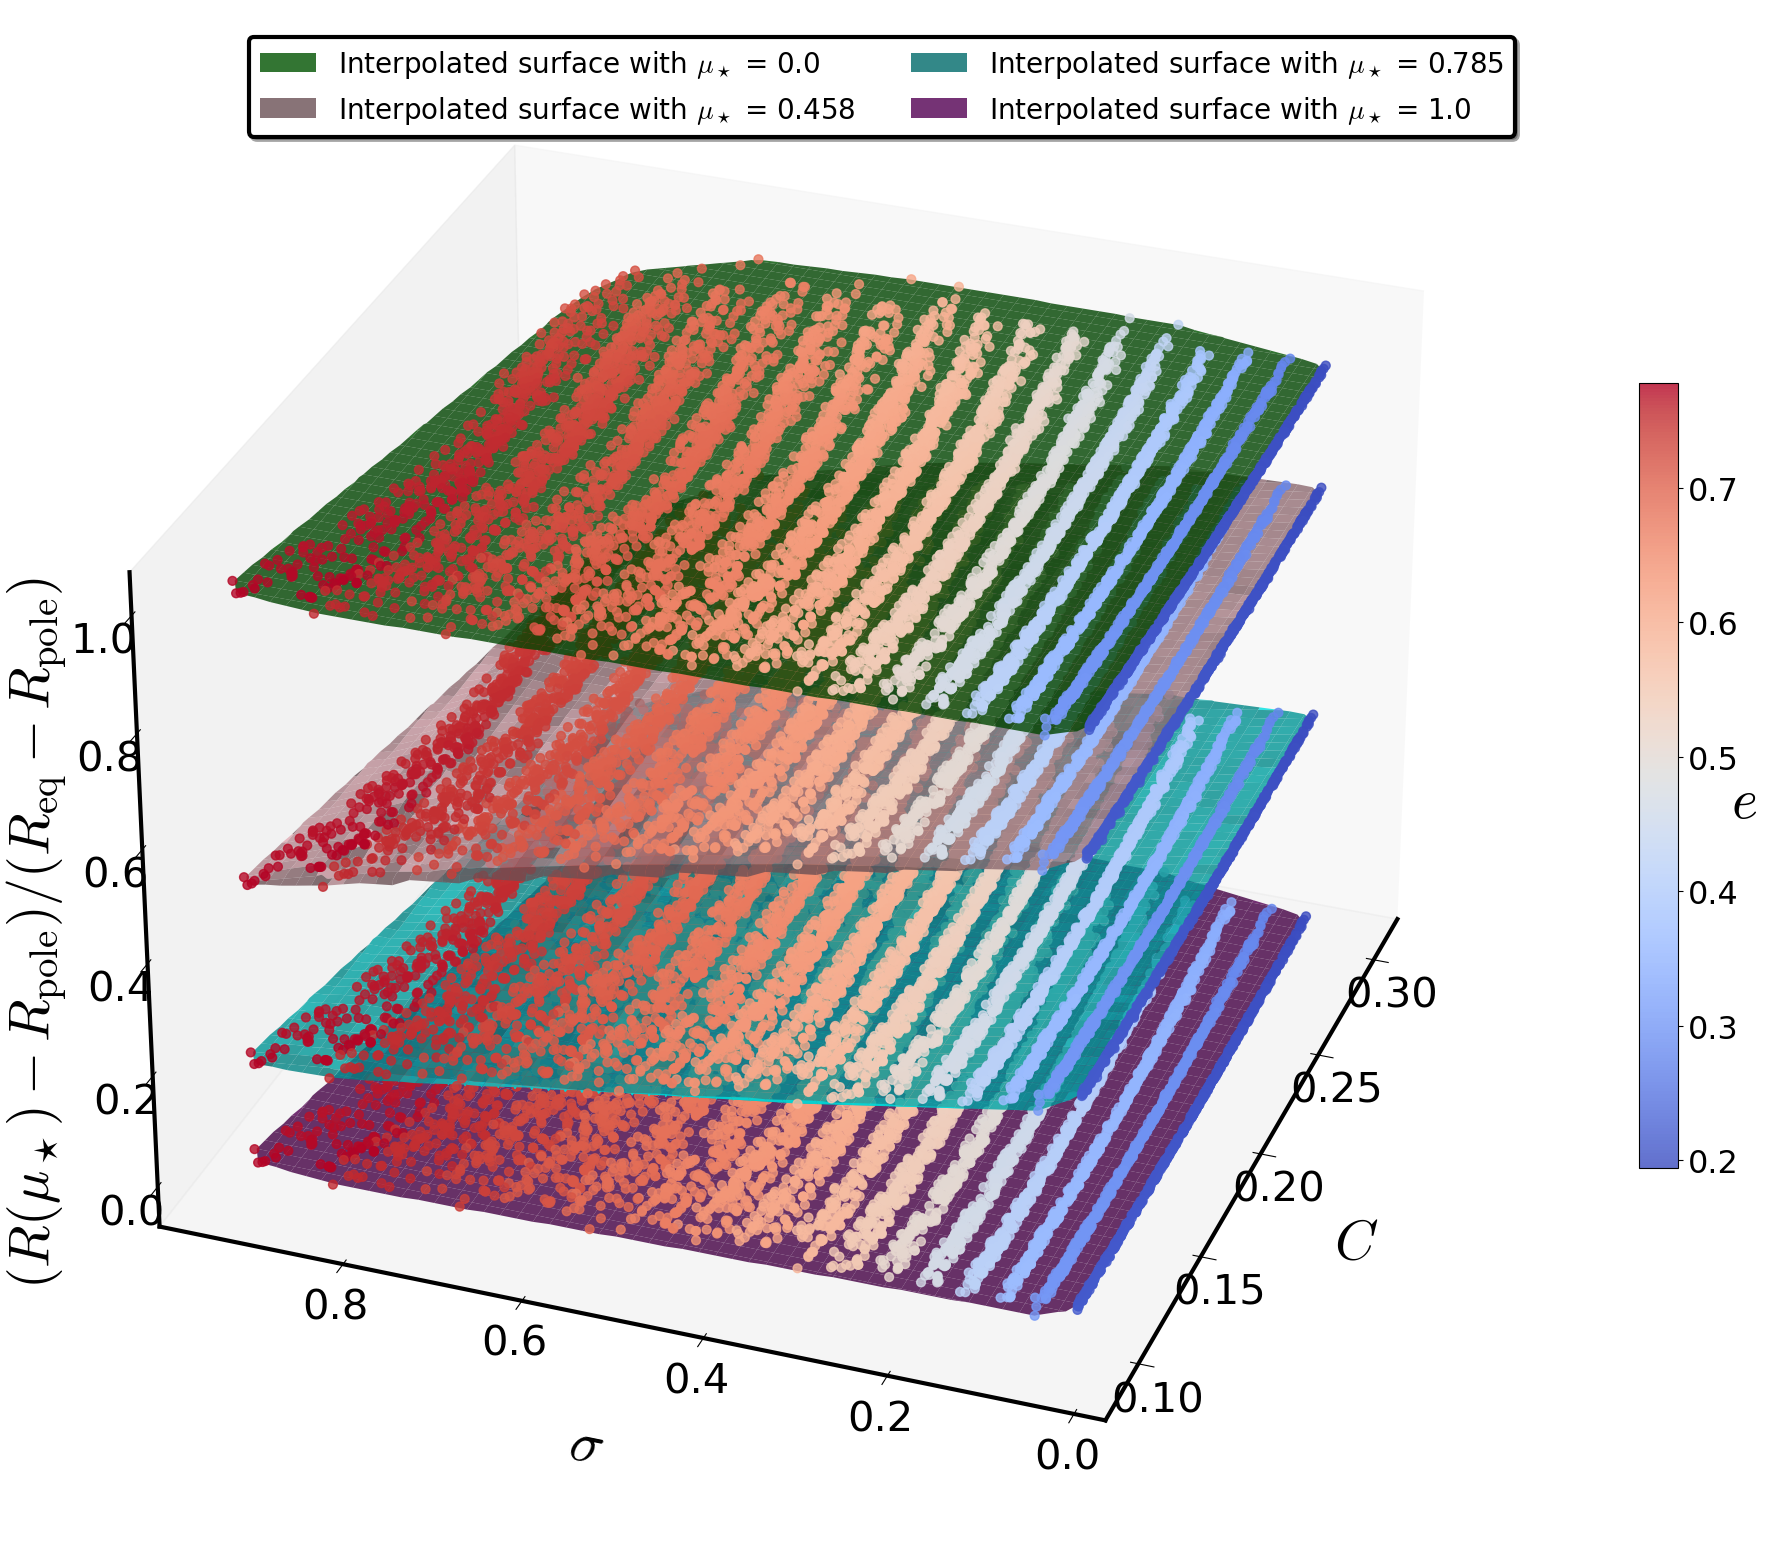

In [14]:
Surface_plot(df_new, x,y,w,z, xlabel=r'$C$',ylabel='$\sigma$',
                     wlabel = r'$e$',zlabel=r'$(R(\mu_\star) - R_{\mathrm{pole}})/(R_{\mathrm{eq}} - R_{\mathrm{pole}})$', 
                     view2=200, n_col=2, border_axes=1, X=None,Y=None,W = None,Z=None, l_w=1.5)

### Universal description for each $\mu$ value

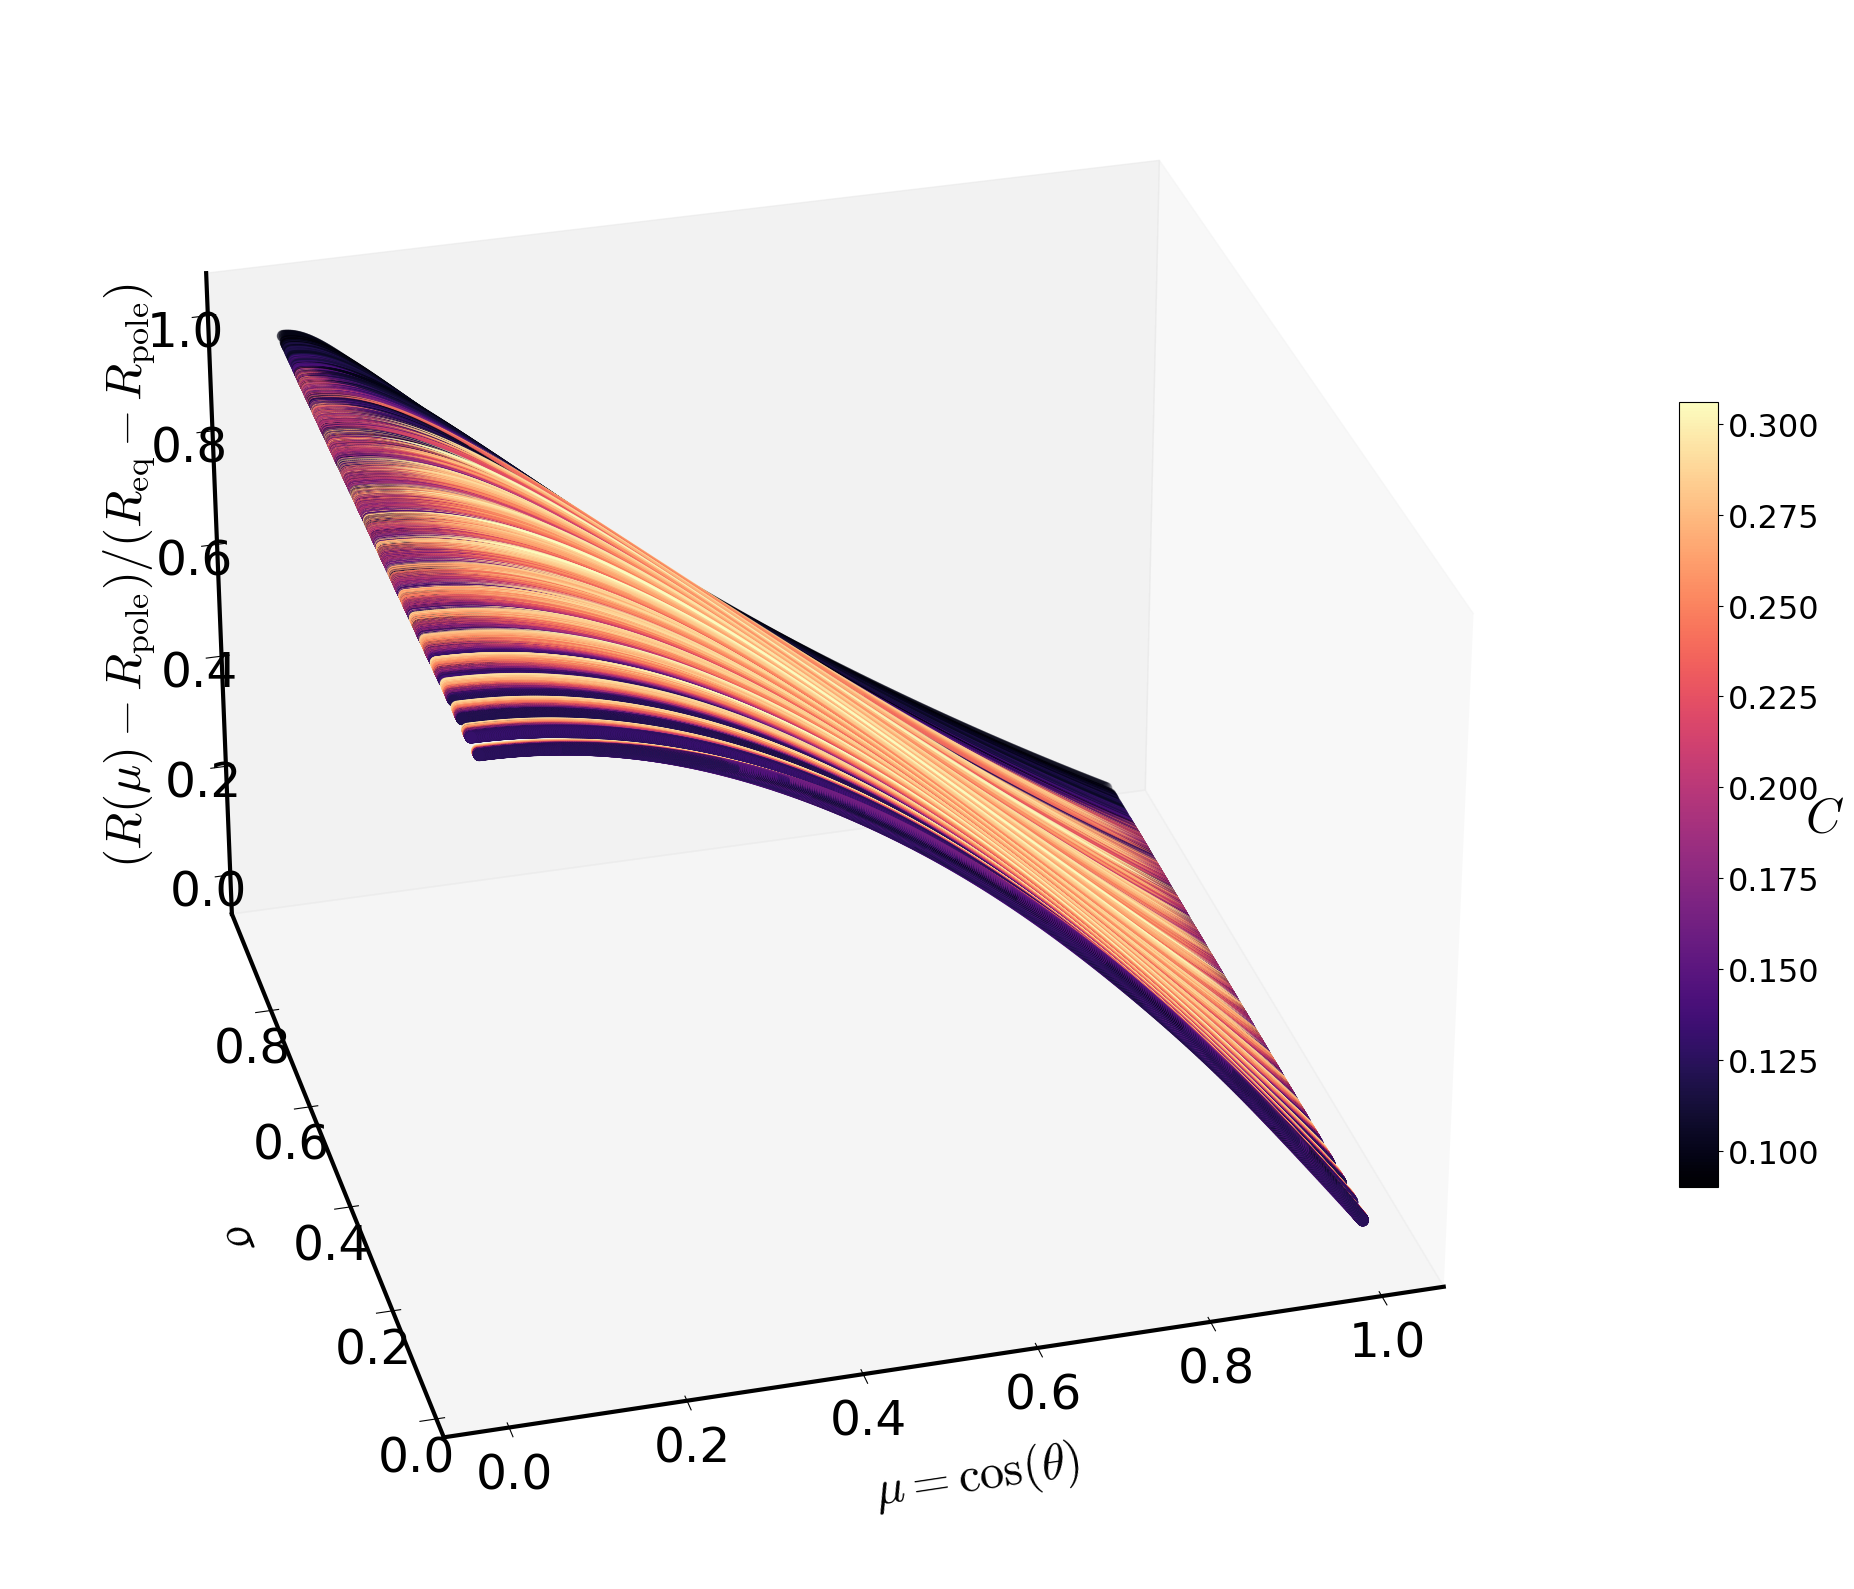

In [15]:
fig = plt.figure(figsize=(20, 16))
labels_text_size = 40
ax = fig.add_subplot(111, projection='3d')
dot_size = 60
font_size = 35
label_pad = 35
label_size = 35

# 3D scatter plot with q encoded as color
scatter = ax.scatter(mu_var, sigma_var, R_min_max, c=C_var, cmap='magma', s=60)  # q affects color and size

cbar = plt.colorbar(scatter,  shrink=0.5, )
cbar.set_label(r'$C$', fontsize=font_size,rotation=0)
cbar.ax.tick_params(labelsize=23)

ax.view_init(30, 255)   
    

ax.set_xlabel(r'$\mu = \cos (\theta)$', fontsize=font_size,labelpad=label_pad) 

ax.set_ylabel(r'$\sigma$', fontsize=font_size,labelpad=label_pad) 

ax.zaxis.set_rotate_label(False) 
ax.set_zlabel(r'$(R(\mu) - R_{\mathrm{pole}})/(R_{\mathrm{eq}} - R_{\mathrm{pole}})$', fontsize=font_size,labelpad=label_pad,rotation = 90) 

ax.zaxis.labelpad = 25
    
ax.xaxis.set_tick_params(labelsize=label_size)
ax.yaxis.set_tick_params(labelsize=label_size)
ax.zaxis.set_tick_params(labelsize=label_size)
    
for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    axis.line.set_linewidth(3)
    
ax.grid(False)
    
plt.tight_layout()

plt.show()

### Percentage error histogram in the test set for the suggested ANN model optimal weights

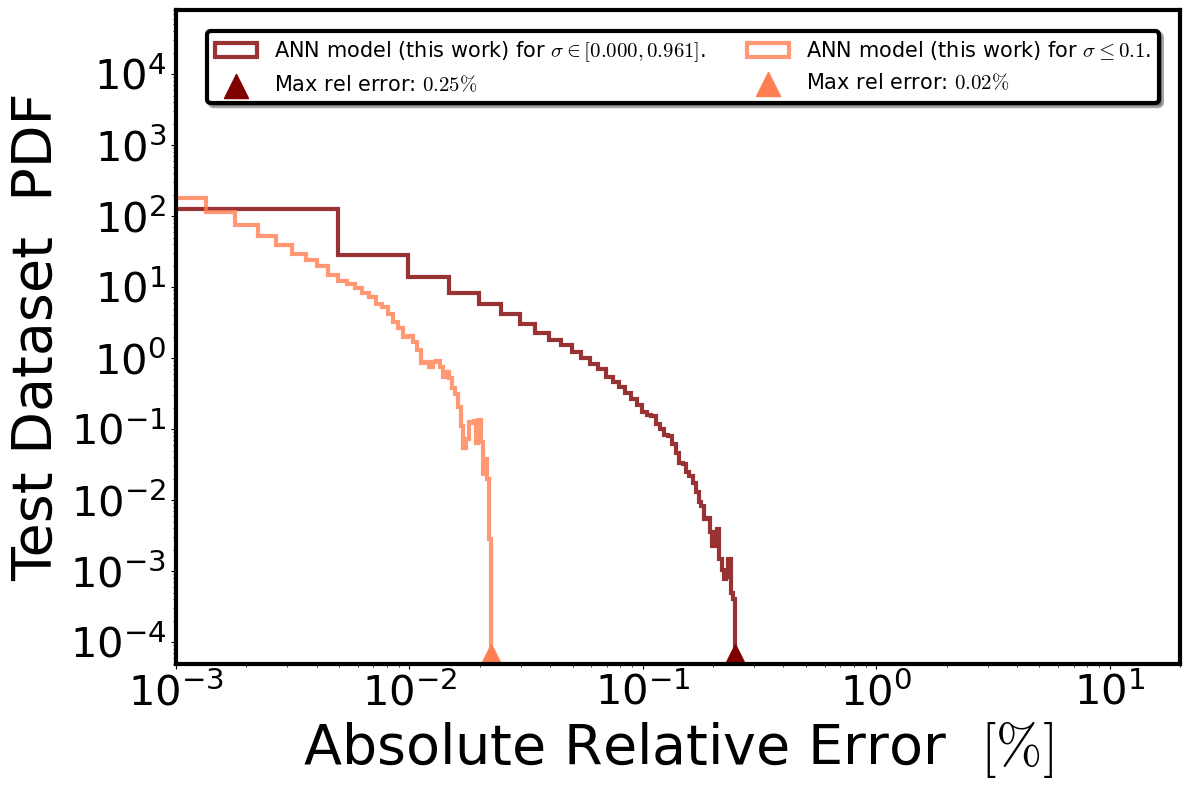

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
labels_text_size = 40
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

xlabel = r'Absolute Relative Error  $[\%]$'
ylabel = r'Test Dataset  PDF'

plt.xlabel(xlabel, size=labels_text_size)
plt.ylabel(ylabel, size=labels_text_size)

bins = 50
alpha = 0.8
# Histogram for the proposed ANN Regression Model
y_reg_model = abs(df['percentange_error']).hist(
                    density = True,
                    lw = 3,
                    bins=bins,
                    edgecolor='maroon',
                    histtype='step',
                    zorder=1, alpha=alpha, 
                    label='ANN model (this work) for $\sigma \in [0.000, 0.961]$.', color='maroon').autoscale(enable=True, axis='both', tight=True)

# Vertical line for the proposed ANN Regression Model
vertical_lines = [abs(df['percentange_error']).max(), None]
plt.scatter(vertical_lines[0], 0.65e-4, color='maroon', marker='^', s=300, zorder=2, label=f"Max rel error: ${np.round(abs(df['percentange_error']).max(),2)} \%$")  # Star marker

# Histogram for the proposed ANN Regression Model
y_reg_model = abs(df[df['sigma']<=0.1]['percentange_error']).hist(
                    density = True,
                    lw = 3,
                    bins=bins,
                    edgecolor='coral',
                    histtype='step',
                    zorder=1, alpha=alpha, 
                    label='ANN model (this work) for $\sigma \leq 0.1$.', color='coral').autoscale(enable=True, axis='both', tight=True)

# Vertical line for the proposed ANN Regression Model
vertical_lines = [abs(df[df['sigma']<=0.1]['percentange_error']).max(), None]

plt.scatter(vertical_lines[0], 0.65e-4, color='coral', marker='^', s=300, zorder=2, label=f"Max rel error: ${np.round(abs(df[df['sigma']<=0.1]['percentange_error']).max(),2)} \%$")  # Star marker

# Customize plot appearance
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(3.0)

# Set logarithmic scale 
plt.xscale('log')
plt.yscale('log')

# Adjust x,y-axis limits (optional, based on log scale)
plt.xlim(0.1e-2,20)
plt.ylim(5e-5,80000)

# Grid, legend, and layout
plt.grid(False)
leg = plt.legend(loc="upper right", ncol=2, borderaxespad=1, prop={'size': 15.},  shadow=True, fontsize="large")
leg.get_frame().set_linewidth(3.0)
leg.get_frame().set_edgecolor('black')
plt.tight_layout()
plt.show()



## ANN Regression Model for star's surface: Evaluation on singular EOS

In [17]:
# Choose the case/EoS of your preference
# In this demo we provide indicatively for demonstration 3 EoS: 1 per star's category investigated

# Hadronic case
#file_name = './Surface models for Hadronic EOS/SLY4/'

# Hyperonic case
#file_name = './Surface models for Hyperonic EOS/DNS/'

# Hybrid case
file_name = './Surface models for Hybrid EOS/KBH(QHC21_AT)/'


In [18]:
spin = 'sigma' 
test_percentage = 0.2

rotational_path = os.path.join(file_name, 'rotational_models.zip')
static_path = os.path.join(file_name, 'static_models.zip')

df_rot_train, df_rot_test = read_zip(rotational_path, spin=spin, test_percentage=test_percentage)
df_stat_train, df_stat_test = read_zip(static_path, spin=spin, test_percentage=test_percentage)

df_train = pd.concat([df_rot_train, df_stat_train], ignore_index=True)
df_test = pd.concat([df_rot_test, df_stat_test], ignore_index=True)

# Free the memory space
del df_rot_train, df_rot_test, df_stat_train, df_stat_test

### Load the Regression Model optimal weights to estimate star's surface

In [19]:
batch_size = 4096
model_path = './Model/Surface/Surface-model.pth'

dataloader_tr, input_dimension, np_features_tr, np_targets_tr = load_stars(df_train, batch_size=batch_size)
dataloader_ts, _, np_features_ts, np_targets_ts = load_stars(df_test, batch_size=batch_size)

regressor = Regressor(input_dimension=input_dimension, feature_scaler=feature_scaler).to(device)
regressor.set_device(device)
regressor.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
regressor.eval()

Regressor(
  (MLP): Sequential(
    (0): Linear(in_features=4, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): Linear(in_features=200, out_features=100, bias=True)
    (3): LeakyReLU(negative_slope=0.1, inplace=True)
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): LeakyReLU(negative_slope=0.1, inplace=True)
    (6): Linear(in_features=50, out_features=25, bias=True)
    (7): LeakyReLU(negative_slope=0.1, inplace=True)
    (8): Linear(in_features=25, out_features=10, bias=True)
    (9): LeakyReLU(negative_slope=0.1, inplace=True)
    (10): Linear(in_features=10, out_features=1, bias=True)
    (11): Sigmoid()
  )
)

### Plot functions associated with residual and percentage errors

In [20]:
def plot_residuals(residual_error, percentage_error):
    witdh, height = 16, 6
    fontsize = 20
    labelsize = 15
    lw = 5
    
    fig, ax = plt.subplots(1, 2, figsize=(witdh, height))
    # Residual error subplot 
    ax[0].plot(residual_error, lw=lw)
    ax[0].set_xlabel(r'Datapoints', fontsize=fontsize)
    ax[0].set_ylabel(r'Residual', fontsize=fontsize)
    ax[0].tick_params(axis='both', which='both', labelsize=labelsize)

    # Percentage error subplot 
    ax[1].plot(percentage_error, lw=lw)
    ax[1].set_xlabel(r'Datapoints', fontsize=fontsize)
    ax[1].set_ylabel(r'Percentage Error$\ [\%]$', fontsize=fontsize)
    ax[1].tick_params(axis='both', which='both', labelsize=labelsize)

    plt.tight_layout()
    plt.show()
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    fontsize = 20
    labelsize = 15
    lw = 5

    # Residual errors histogram
    ax[0].hist(residual_error, lw=lw)
    ax[0].set_ylabel(r'Data points', fontsize=fontsize)
    ax[0].set_xlabel(r'Residual', fontsize=fontsize)
    ax[0].tick_params(axis='both', which='both', labelsize=labelsize)

    # Percentage errors histogram
    ax[1].hist(percentage_error, lw=lw)
    ax[1].set_ylabel(r'Data points', fontsize=fontsize)
    ax[1].set_xlabel(r'Percentage Error $[\%]$', fontsize=fontsize)
    ax[1].tick_params(axis='both', which='both', labelsize=labelsize)

    plt.tight_layout()
    plt.show()

In [21]:
def plot_surface(mu, model_estimation, real_targets, C, sigma):
    witdh, height = 10, 6
    fontsize = 20
    labelsize = 20
    lw = 5

    fig, ax = plt.subplots(figsize=(witdh, height))
    ax.plot(mu, model_estimation, lw=lw, c='maroon', label='ANN model (this work)')
    ax.scatter(mu, real_targets, c='black', s=20, marker='o', label='Numerical Data')
    
    plt.ylim(real_targets.min()-0.5, real_targets.max()+0.5)
    plt.xlabel(r'$\mu = \cos(\theta)$', fontsize=fontsize)
    plt.ylabel(r'$R(\mu) \ [\mathrm{km}]$', fontsize=fontsize)
    plt.title(f'NS model with C={round(C,3)}, $\sigma$ = {round(sigma,3)}')
    plt.legend(loc='best', prop={'size':fontsize}, shadow=True, fontsize='large')
    ax.tick_params(axis='both', which='both', labelsize=labelsize)

    leg = plt.legend(loc="upper right", ncol=2, borderaxespad=1, prop={'size': 15.},  shadow=True, fontsize="large")
    leg.get_frame().set_linewidth(3.0)
    leg.get_frame().set_edgecolor('black')
    plt.tight_layout()
    plt.show()
    

#### Universal relations suggested in this work for the parameters $e = \sqrt{1-(R_p/R_e)^2}$ and $\mathcal{R} \equiv R_p/R_e$ 

In [22]:
#def eccentricity(C, sigma):
#    return (
#        -99.173162625833 * C**5 +68.055729822908 * C**4 * sigma + 137.191420602024 * C**4 +12.9349885313244 * C**3 * sigma**2 -
#        57.474308297241 * C**3 * sigma -67.7948794729071 * C**3 -9.03315944594535 * C**2 * sigma**3 + 8.08346062523145 * C**2 * sigma**2 +
#        9.19713339469957 * C**2 * sigma + 14.9006458417145 * C**2 + 4.84885244516378 * C * sigma**4 -
#        6.44626099699536 * C * sigma**3 +2.75499036217858 * C * sigma**2 -
#        1.3329369261108 * C * sigma - 1.52533604289959 * C + 4.71450473450295 * sigma**5 -
#        13.8547513636472 * sigma**4 + 15.4712200610891 * sigma**3 - 8.71280504897915 * sigma**2 +
#        3.0422989983075 * sigma + 0.182560763719325
#    )

#def R_pole(R_e, C, sigma):
#    return (
#        R_e*(68.7151320054541 * C**5 -117.228807812831 * C**4 * sigma -
#        71.6699195745365 * C**4 - 8.83436790963497 * C**3 * sigma**2 +
#        90.4556842423828 * C**3 * sigma + 28.980101203154 * C**3 -
#        2.1673404784385 * C**2 * sigma**3 + 4.94947873047332 * C**2 * sigma**2 -
#        21.6125323056704 * C**2 * sigma - 5.6347743027431 * C**2 + 0.274033536311414 * C * sigma**4 +
#        1.01941492279495 * C * sigma**3 - 1.95940441780677 * C * sigma**2 +
#        2.60894540594265 * C * sigma + 0.522844117974324 * C + 0.627942468515494 * sigma**5 -
#        1.16678579309014 * sigma**4 + 0.508122852358802 * sigma**3 + 0.371402374708614 * sigma**2 -
#        0.784944132327725 * sigma + 0.981279105367004)
#    )

### Select NS model for surface illustration and residuals visualization

In [23]:
# Select Set (Train/Test)
is_train = True # True or False

# Select your favorite Star
star_index = 110

# Do not change
low = star_index * N_MU
high = (star_index + 1) * N_MU

select_set = lambda is_train, df_train, df_test: df_train if is_train else df_test
select_features = lambda is_train, np_features_tr, np_features_ts: np_features_tr if is_train else np_features_ts
select_targets = lambda is_train, np_targets_tr, np_targets_ts: np_targets_tr if is_train else np_targets_ts
    
# Select Set (Train/Test)
df_set = select_set(is_train, df_train, df_test)
features = select_features(is_train, np_features_tr, np_features_ts)
targets = select_targets(is_train, np_targets_tr, np_targets_ts)


# estimate the star's surface using the ANN model
estimation = regressor.predict(features[low:high])
maxmin_diff = df_set['Req_num'].iloc[low] - df_set['Rpole_num'].iloc[low]
min_ = df_set['Rpole_num'].iloc[low]

# Using results from the suggested universal relations:
#maxmin_diff = df_set['Req_num'].iloc[low] -  R_pole(df_set['Req_num'].iloc[low], df_set['C'].iloc[low], df_set['sigma'].iloc[low])
#min_ = R_pole(df_set['Req_num'].iloc[low], df_set['C'].iloc[low], df_set['sigma'].iloc[low])
###################################################################################################################################
# Static case
if np.all(df_set['sigma'].iloc[low:high] == 0):
    model_estimation = estimation * df_set['Req_num'].iloc[low]
    real_targets = targets[low:high] * df_set['Req_num'].iloc[low]
# Rotational case
else:
    model_estimation = estimation * (maxmin_diff) + min_ 
    real_targets = targets[low:high] * (maxmin_diff) + min_
    
mu = df_set['cos(theta)'].iloc[low:high]

### Residual and Percentage error representations

In [24]:
residual_error = model_estimation - real_targets
percentage_error = (residual_error / real_targets) * 100

### Error distributions a singular NS configuration

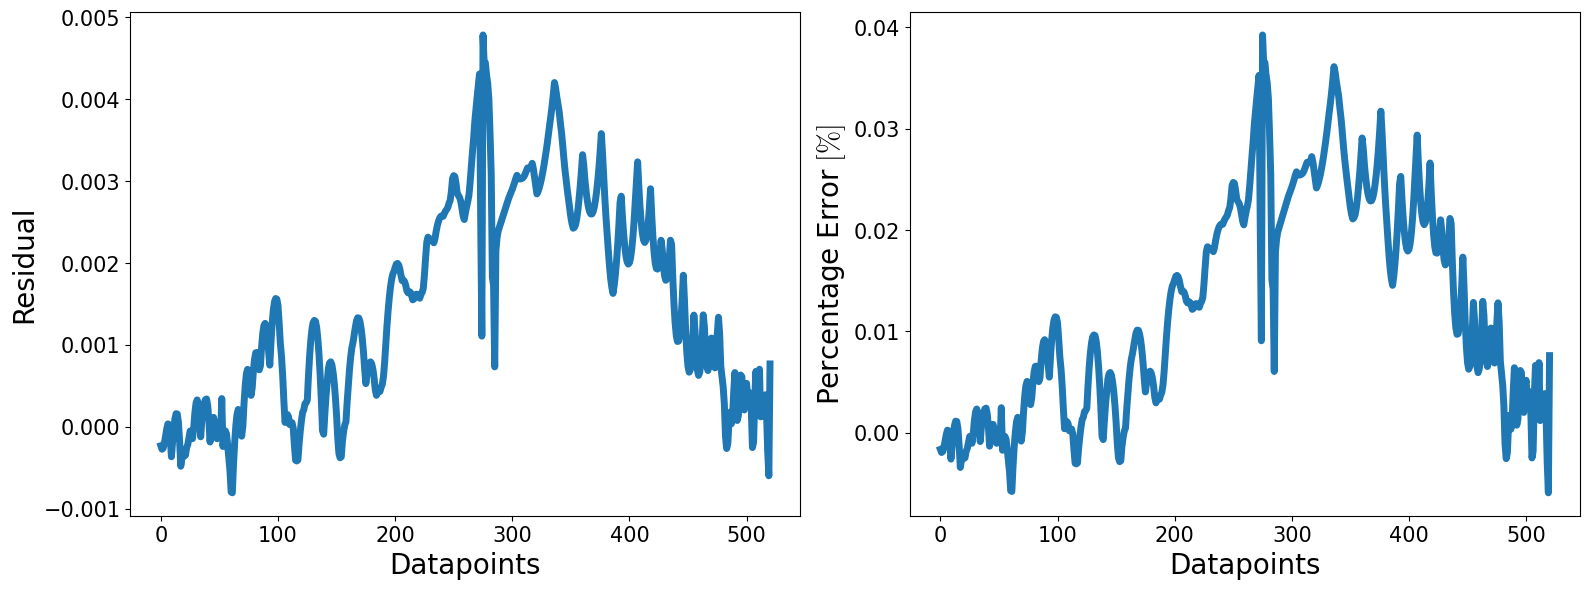

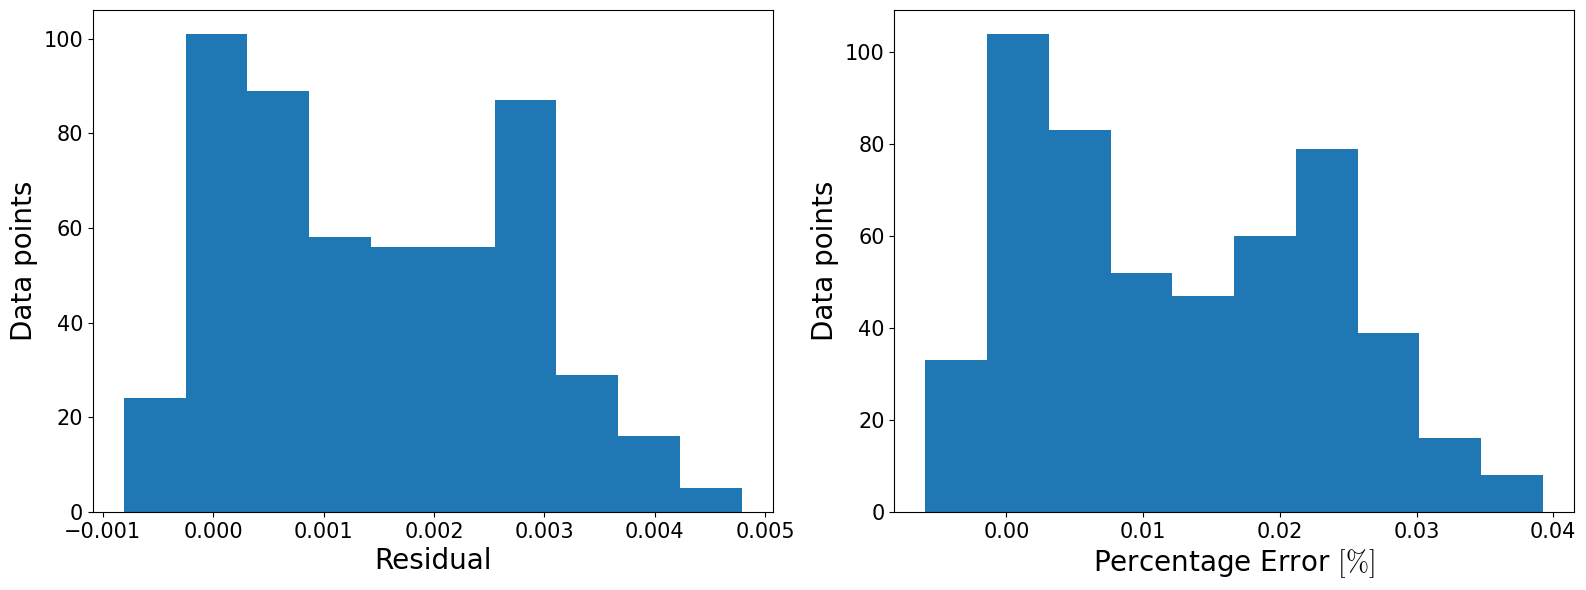

In [25]:
plot_residuals(residual_error, percentage_error)

### Surface $R(\mu)$ for an indicative NS configuration

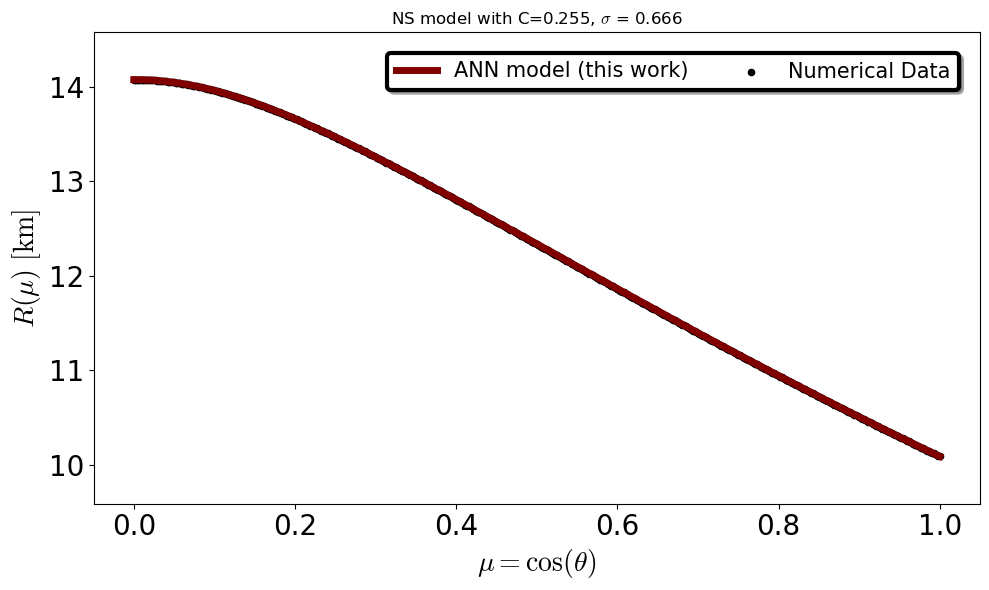

In [26]:
plot_surface(mu, model_estimation, real_targets, df_set['C'].iloc[star_index * N_MU], df_set['sigma'].iloc[star_index * N_MU])

### Visualization of the all the surface curves in the selected set (Train/Test) dataset for the specific EOS loaded

In [27]:
def calculate_model_estimation(C, sigma, R_pole, R_eq):
    num = 50
    mu = np.linspace(0, 1, num=num, dtype=np.float32)
    C_np = np.array([C for _ in range(0, num)], dtype=np.float32)
    sigma_np = np.array([sigma for _ in range(0, num)], dtype=np.float32)
    e_np = np.array([np.sqrt(1 - np.square(R_pole / R_eq)) for _ in range(0, num)], dtype=np.float32)
    x = torch.tensor(np.array([mu, C_np, sigma_np, e_np])).T.to(device) # Convert the argument list to array for optimization 
    model_estimation = regressor(x) * (R_eq - R_pole) + R_pole
    model_estimation = model_estimation.cpu().detach().numpy()
    
    ##########################################################################
    #Convert the estimation list to 1-d array with dtype float 32 in order 
    #to have the same dimenensions and dtype with mu = cos(theta)
    model_estimation = model_estimation.ravel().astype(np.float32)
    ##########################################################################
    
    return mu, model_estimation

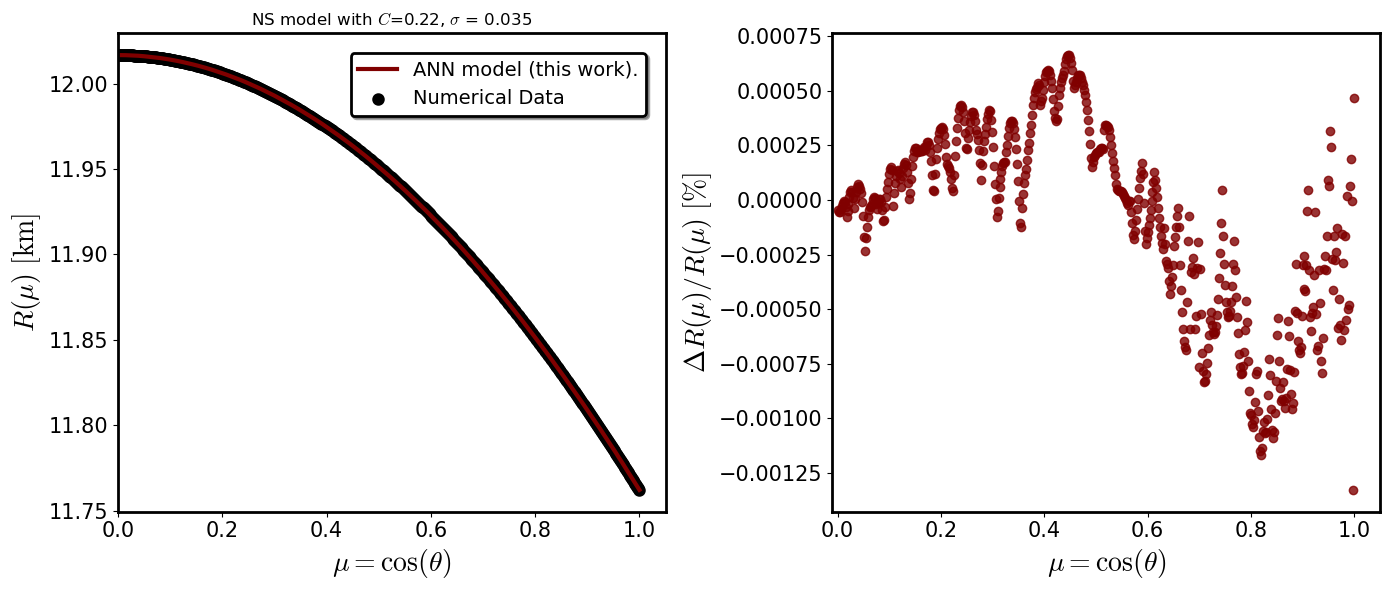

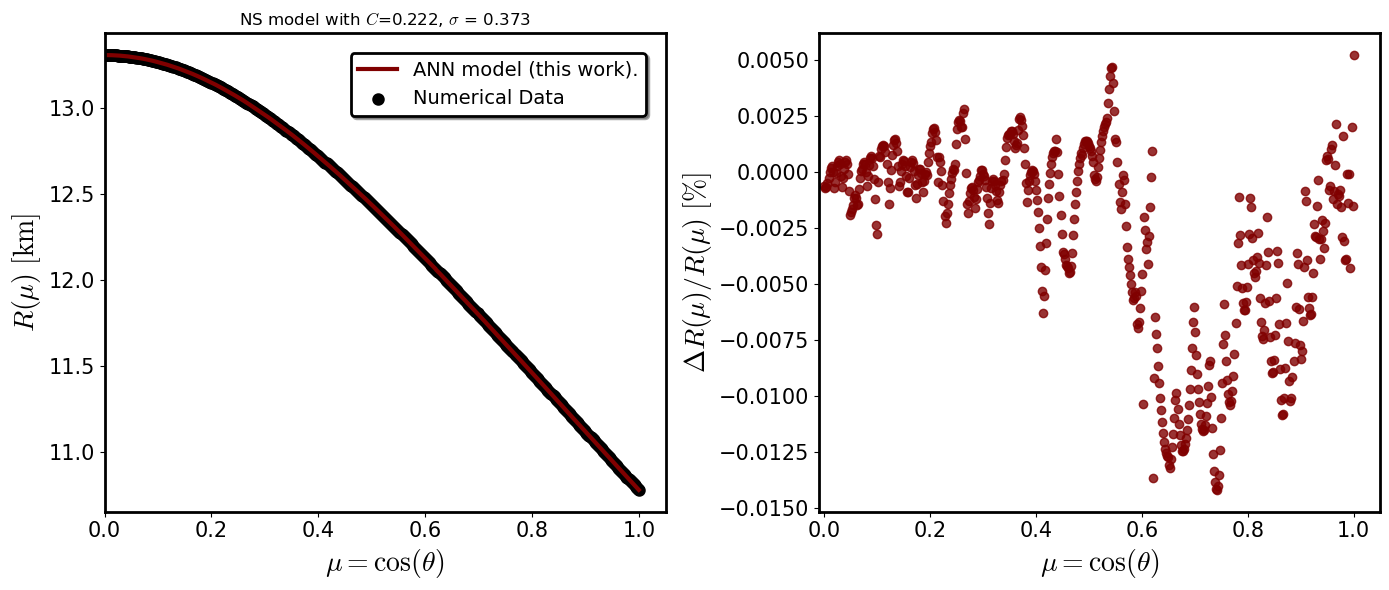

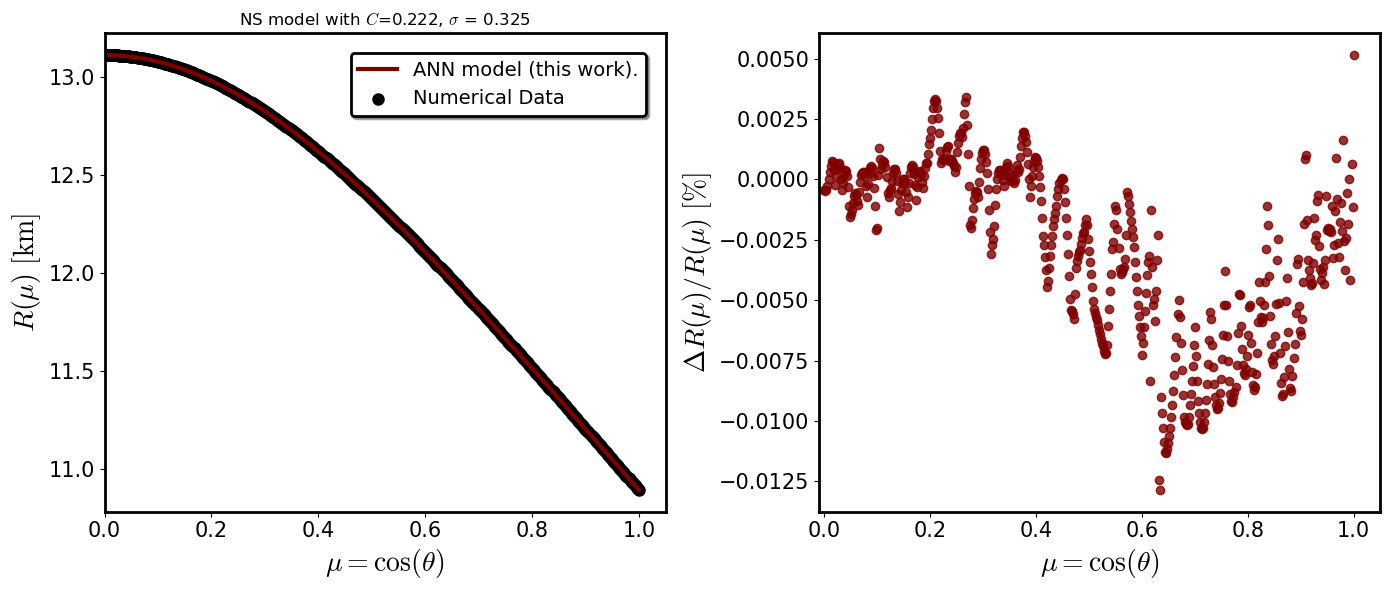

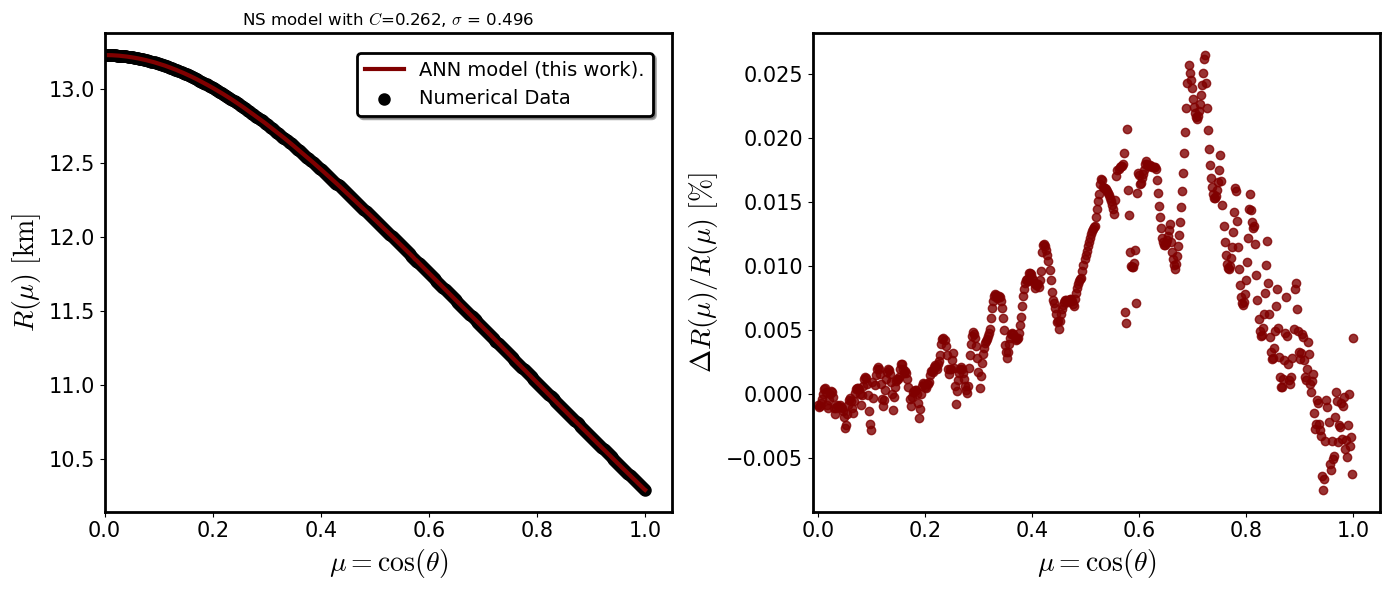

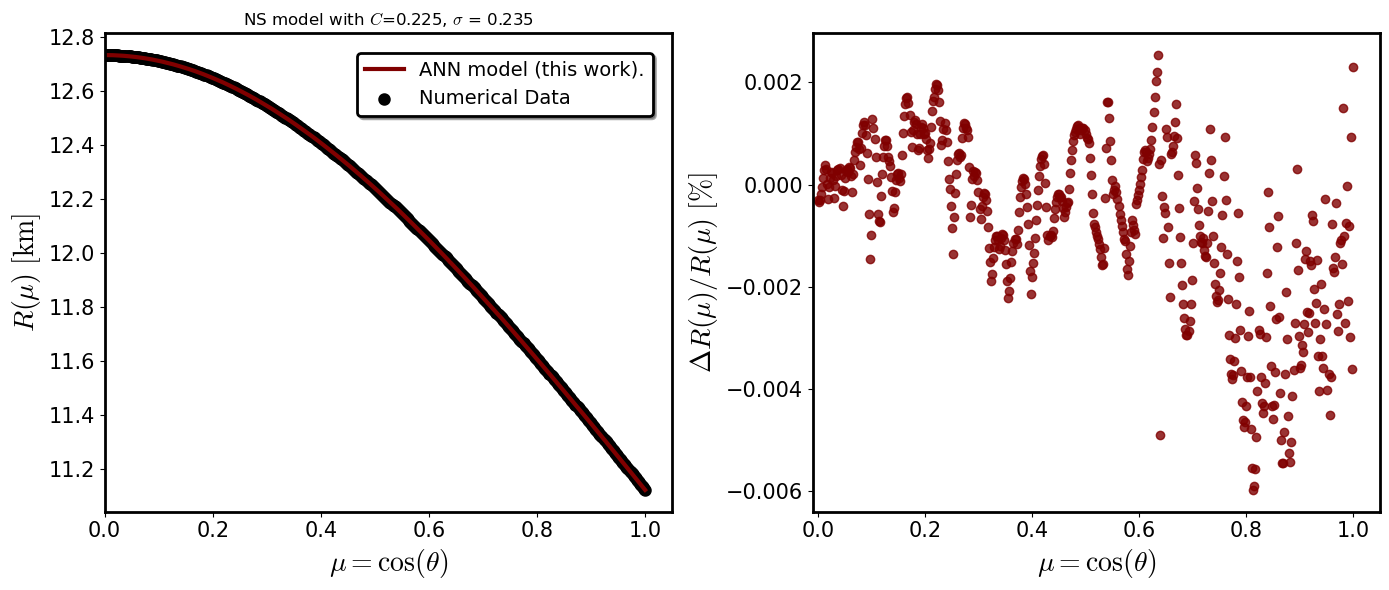

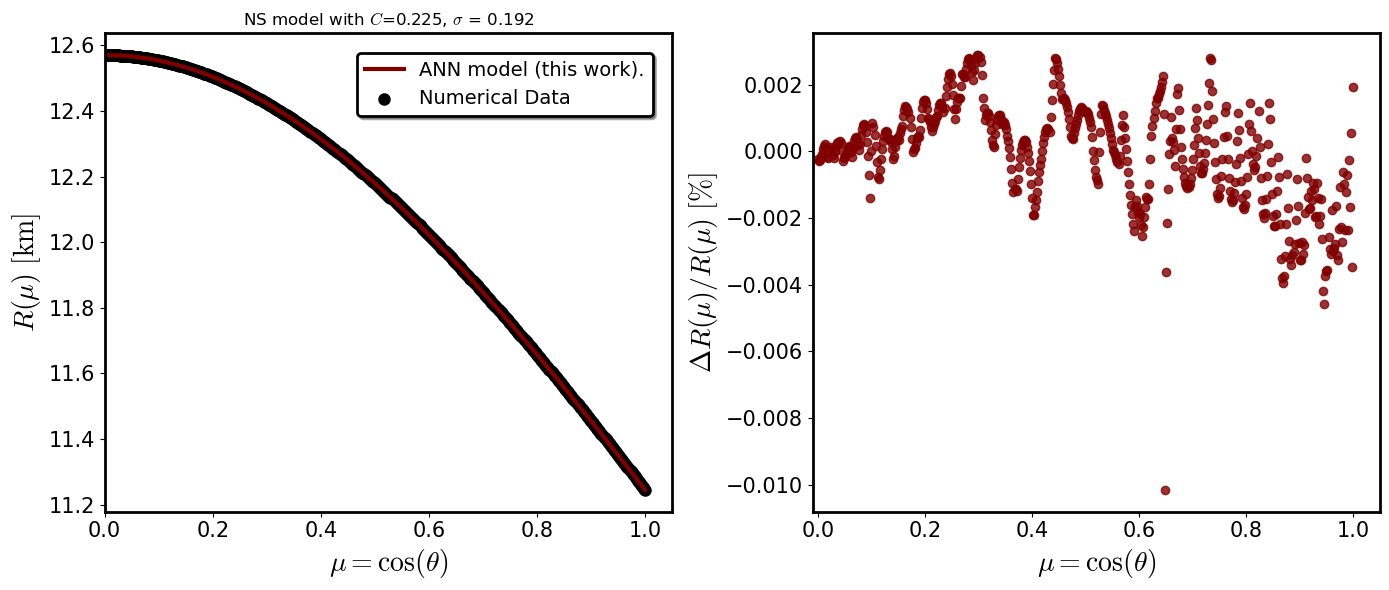

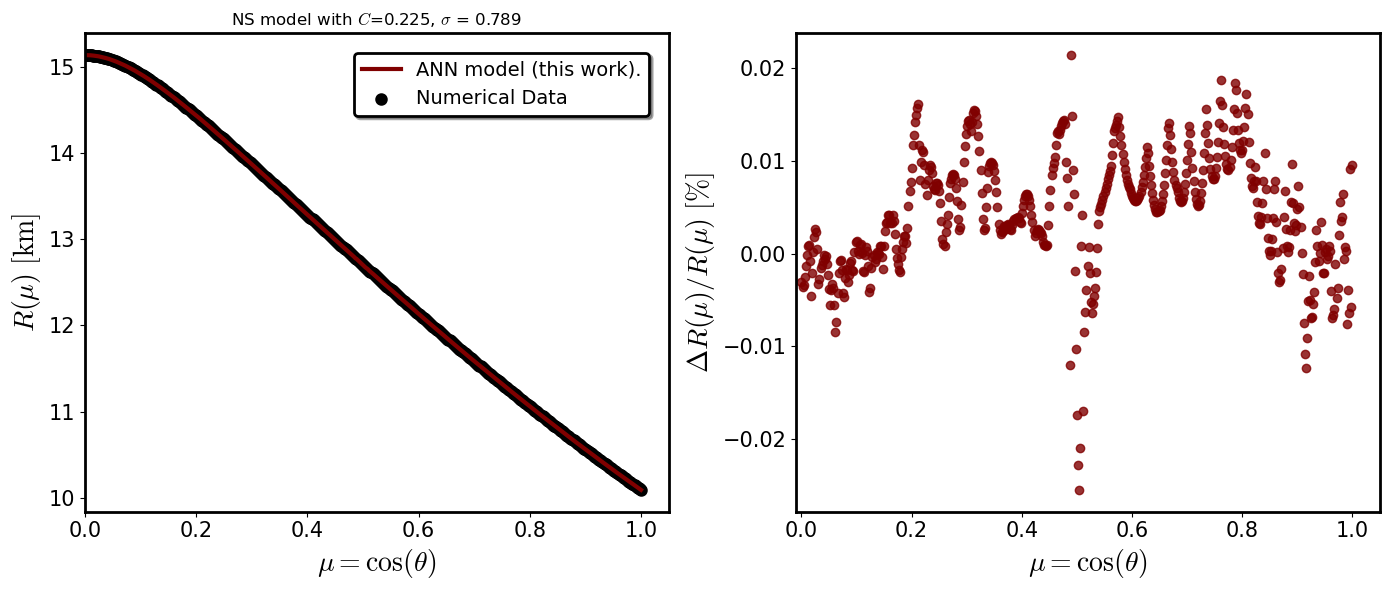

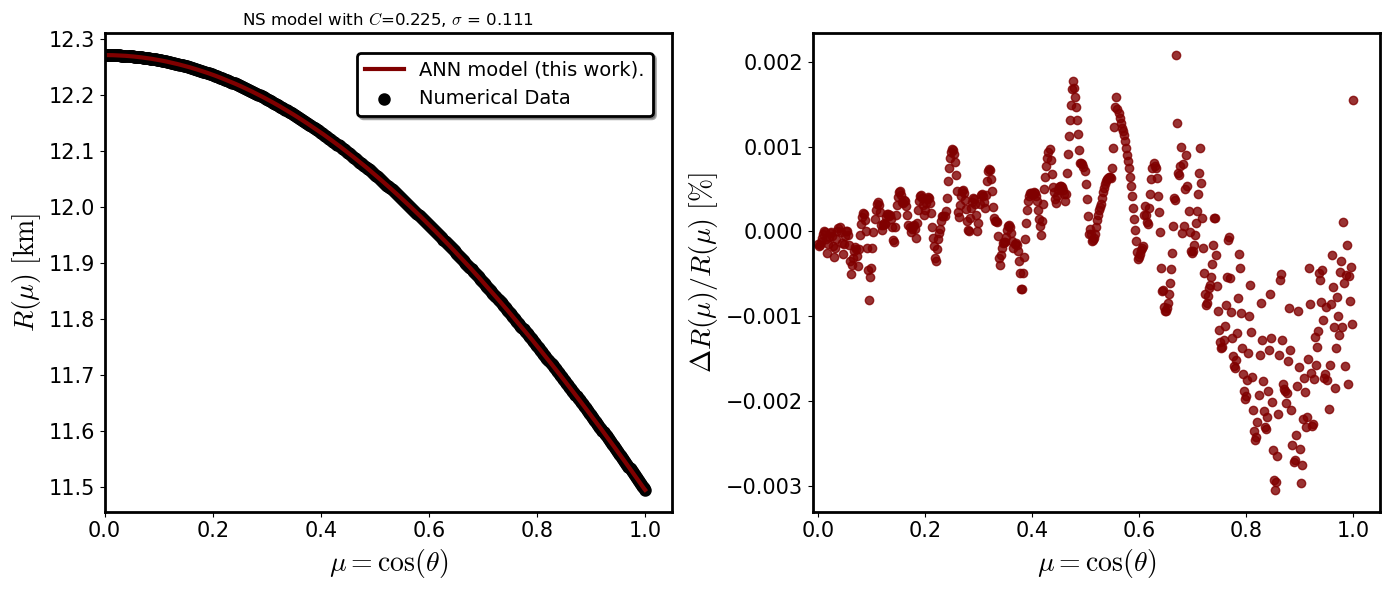

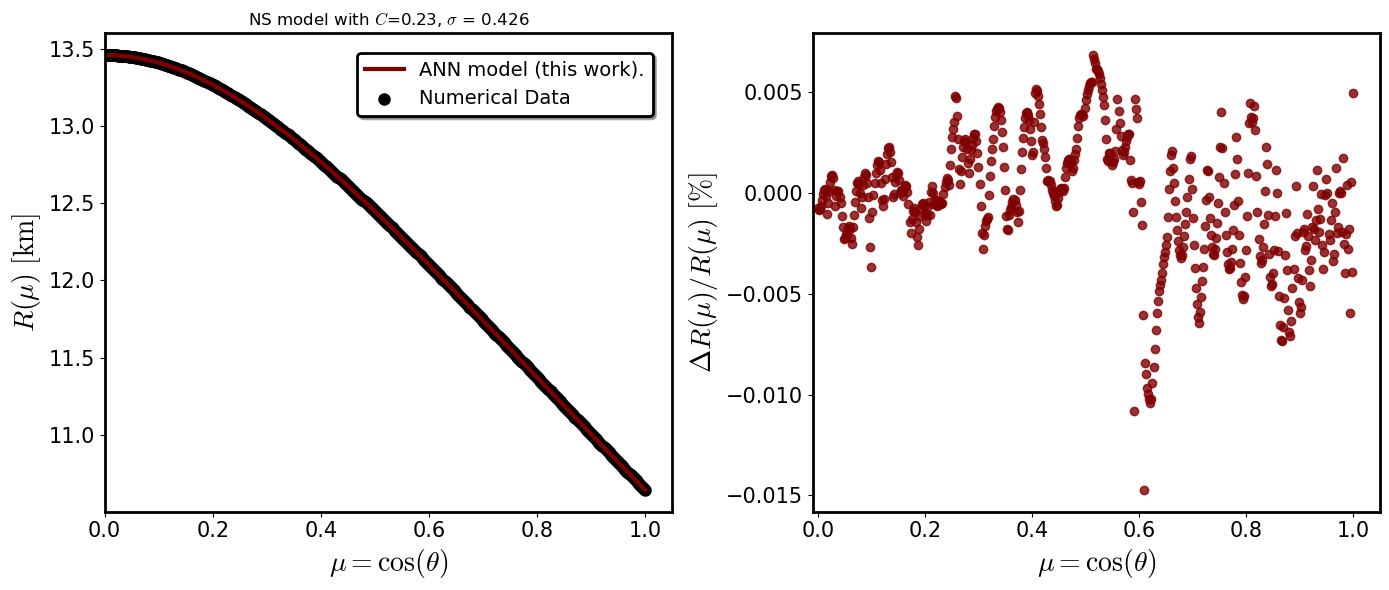

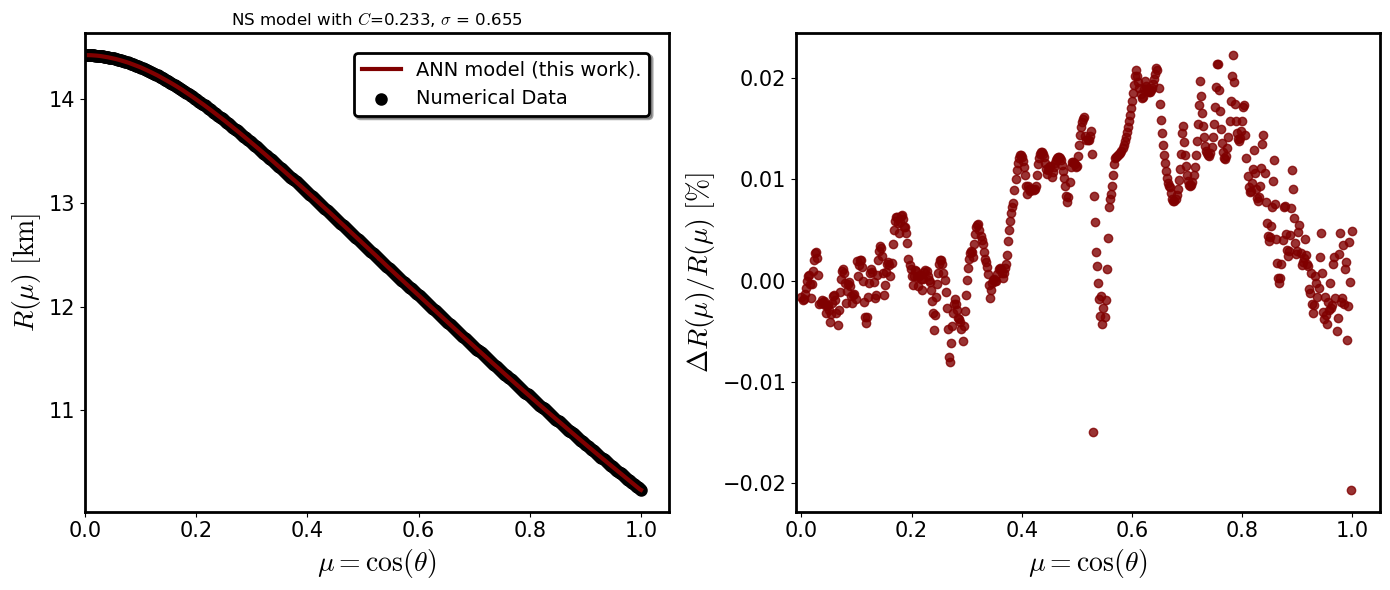

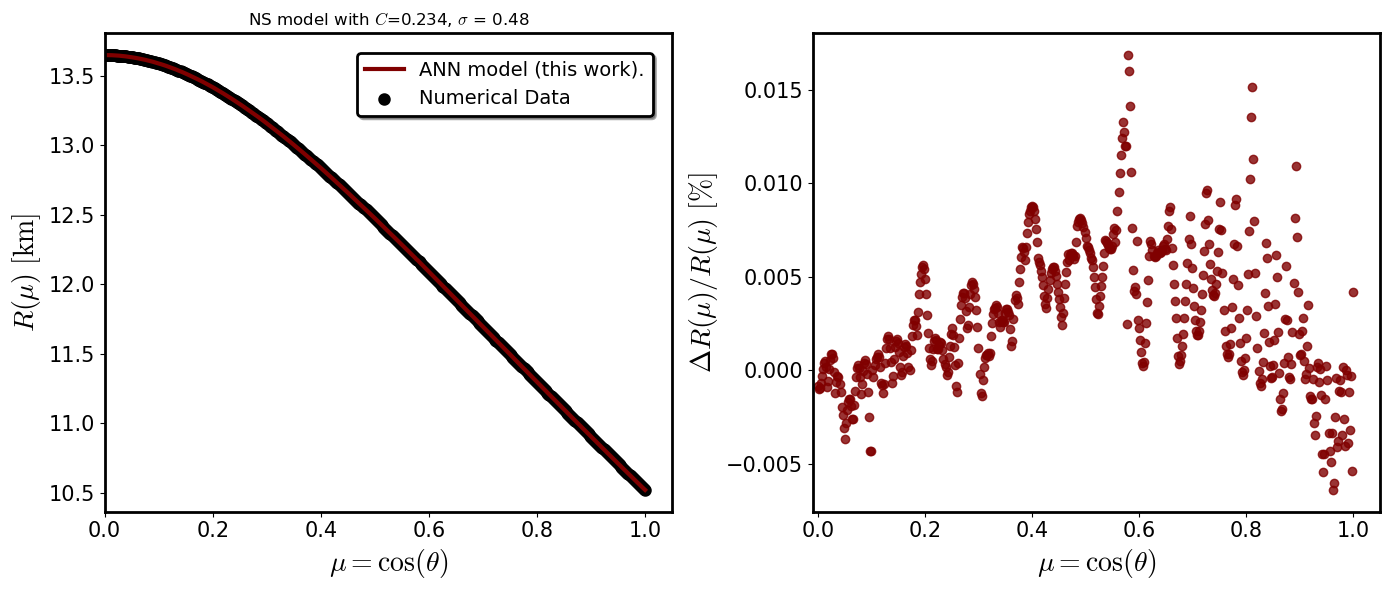

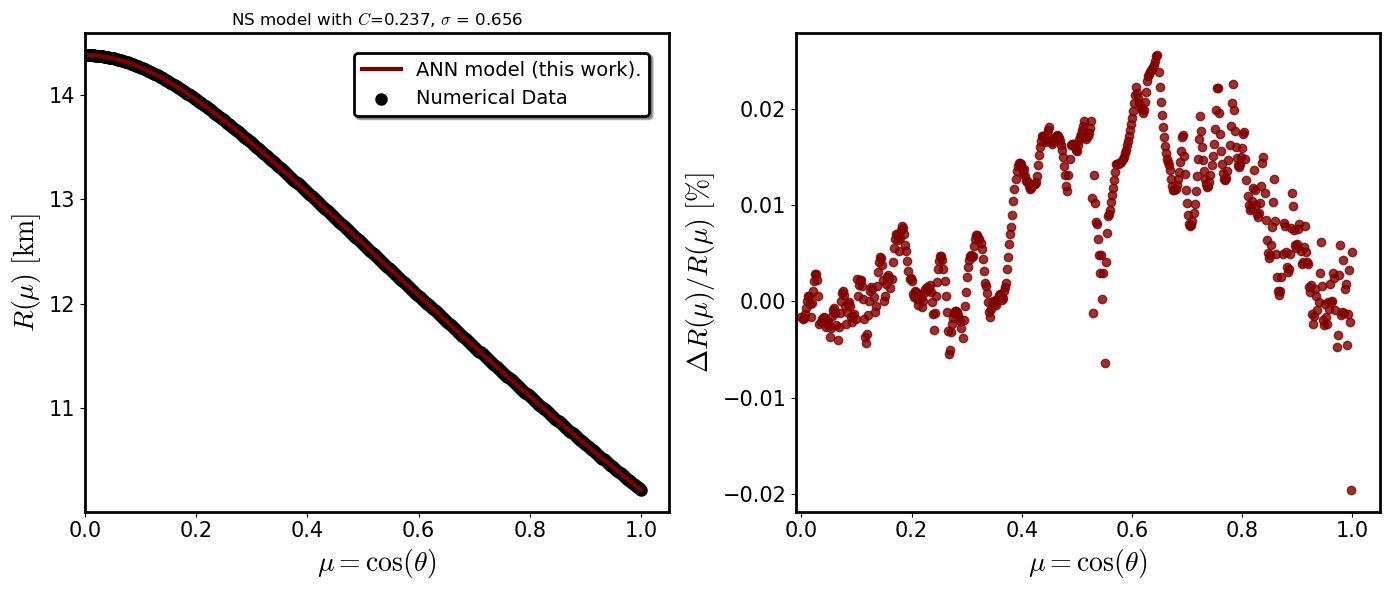

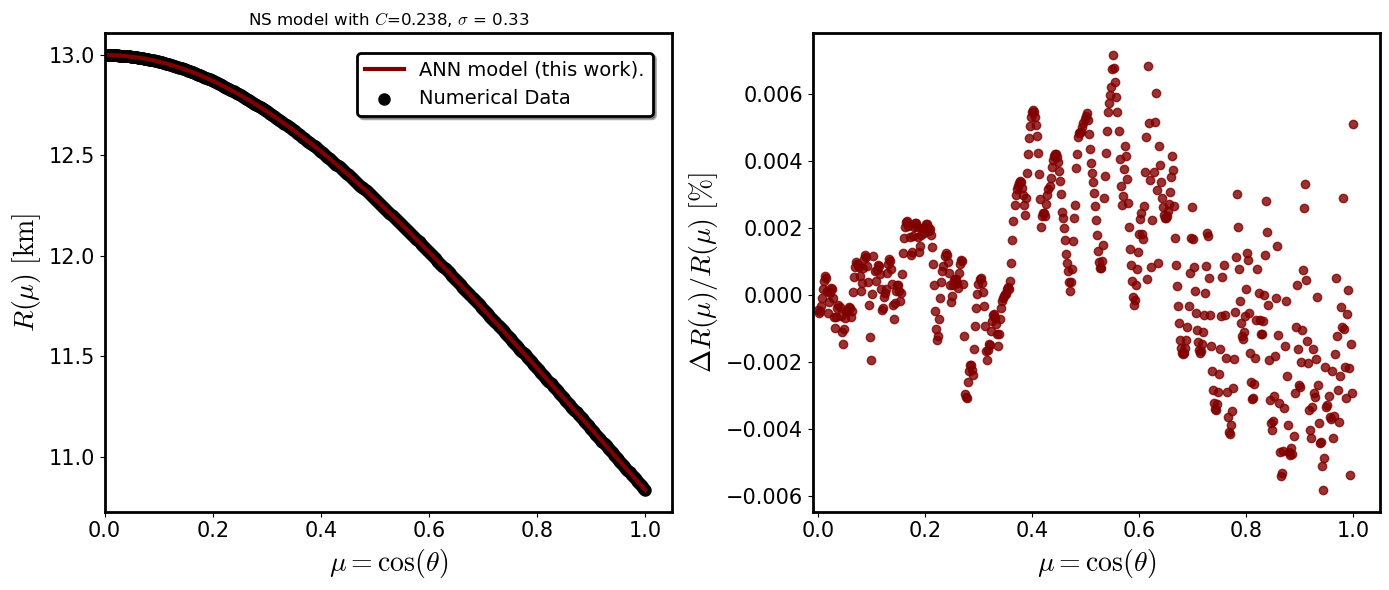

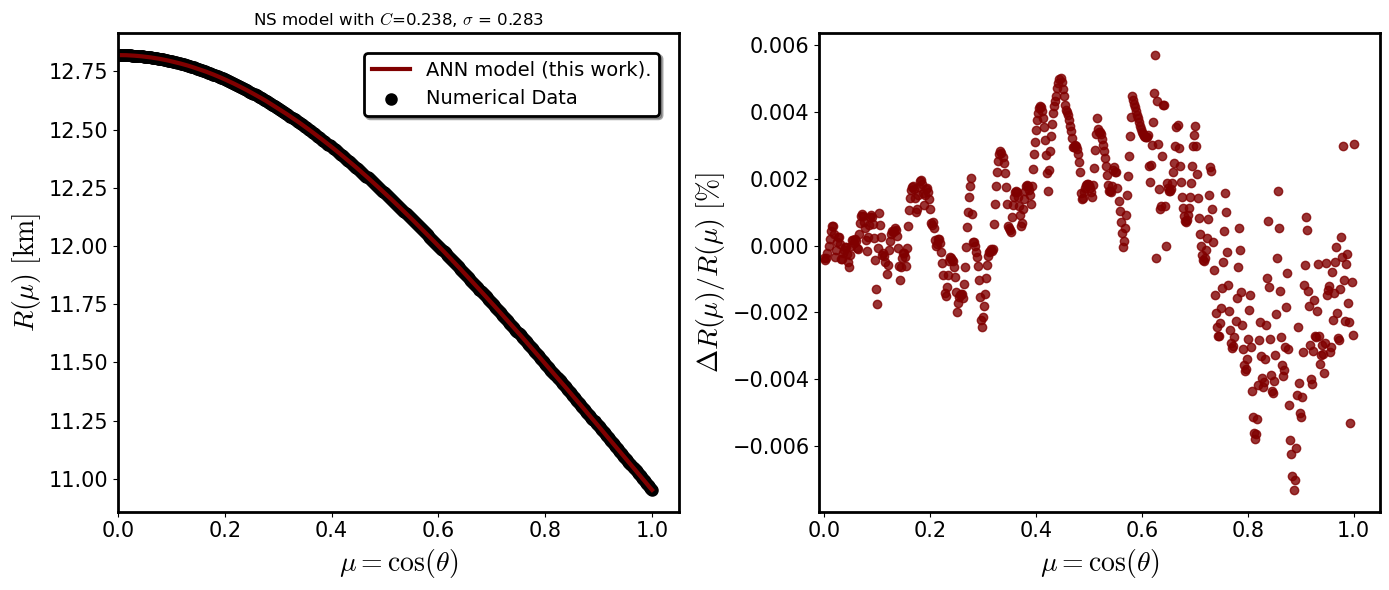

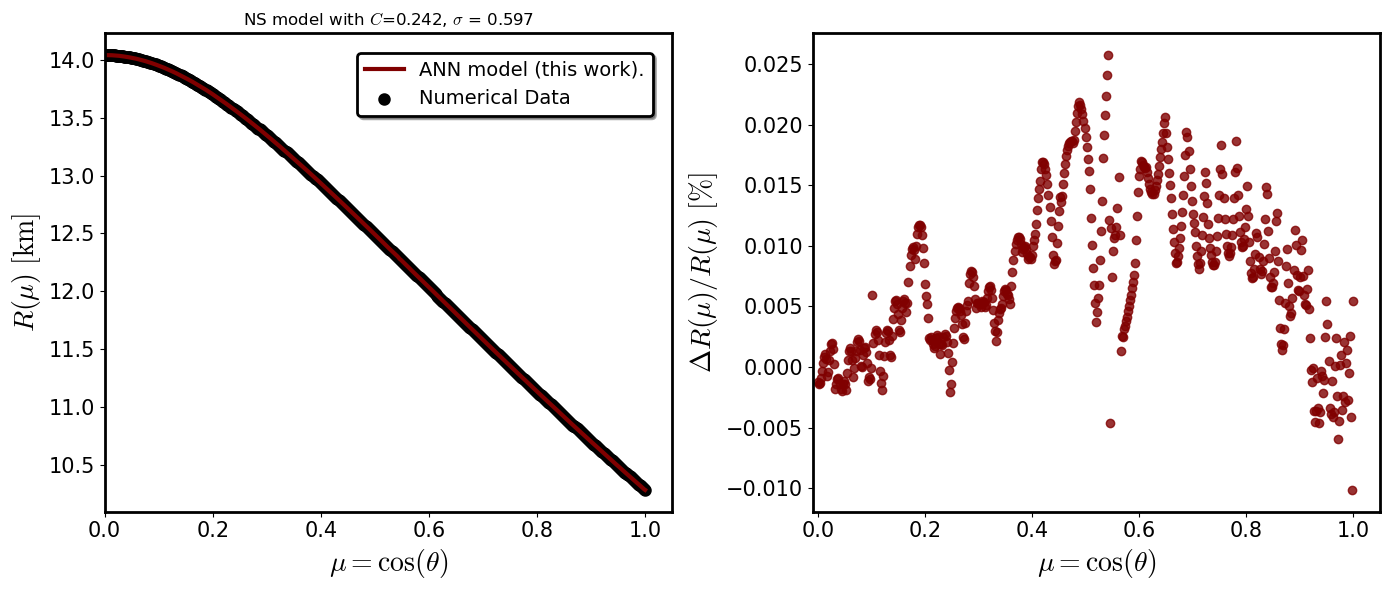

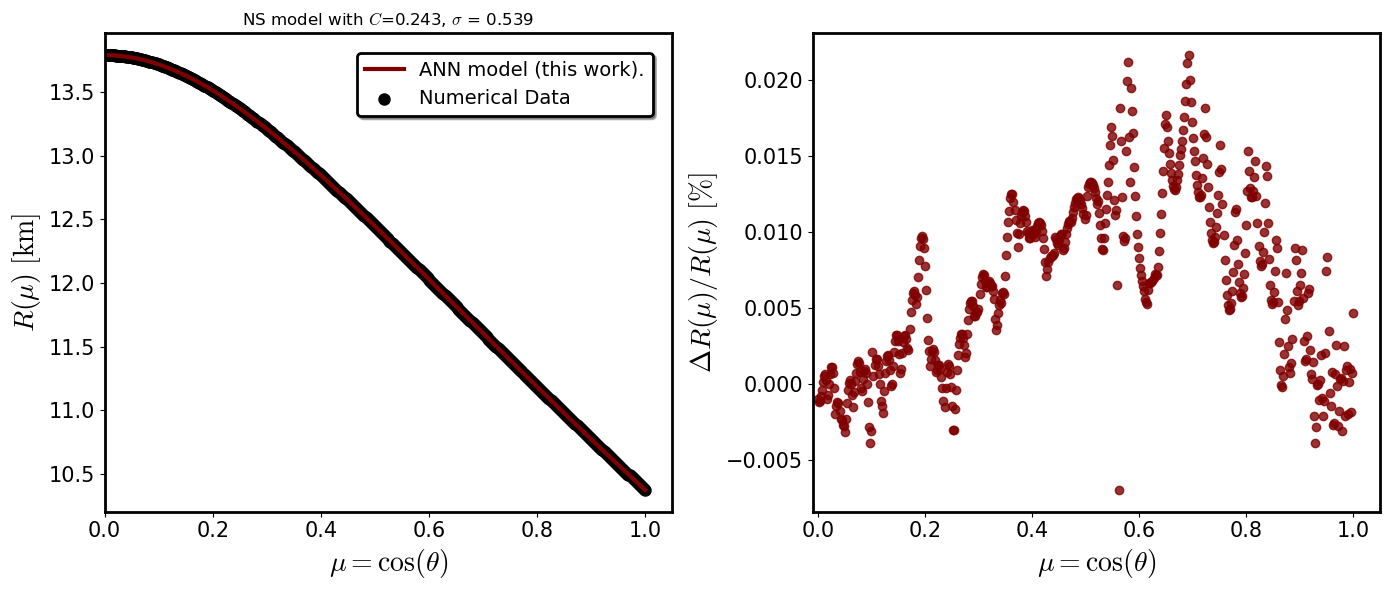

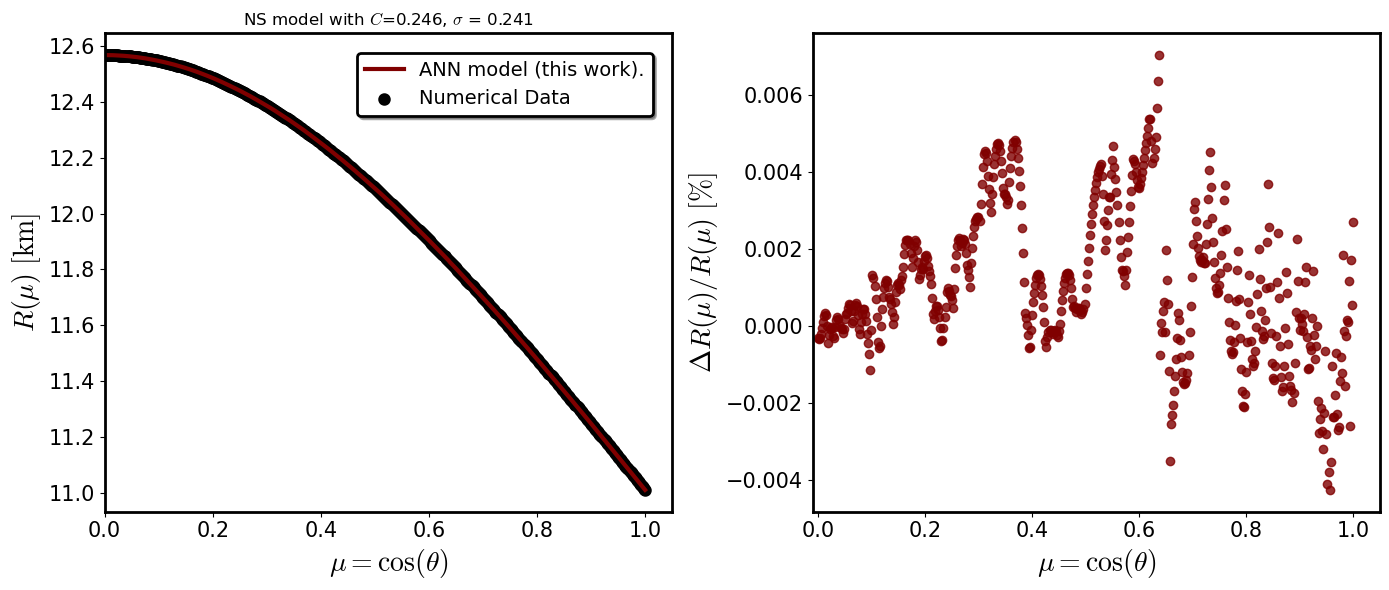

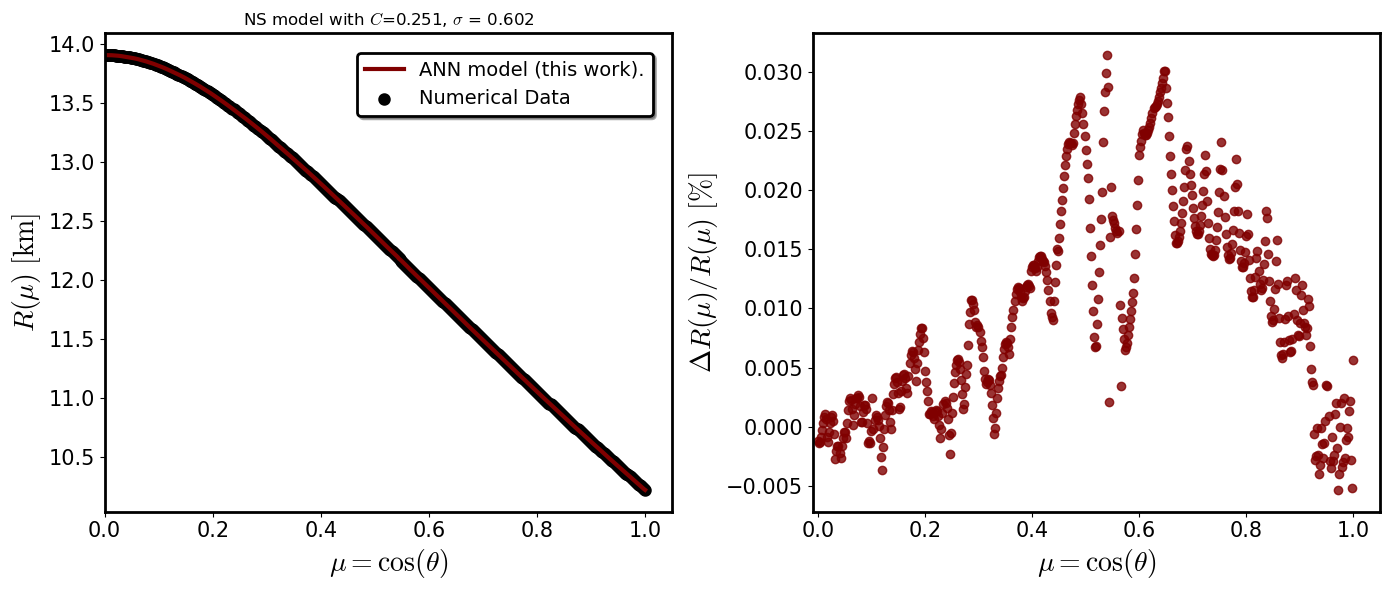

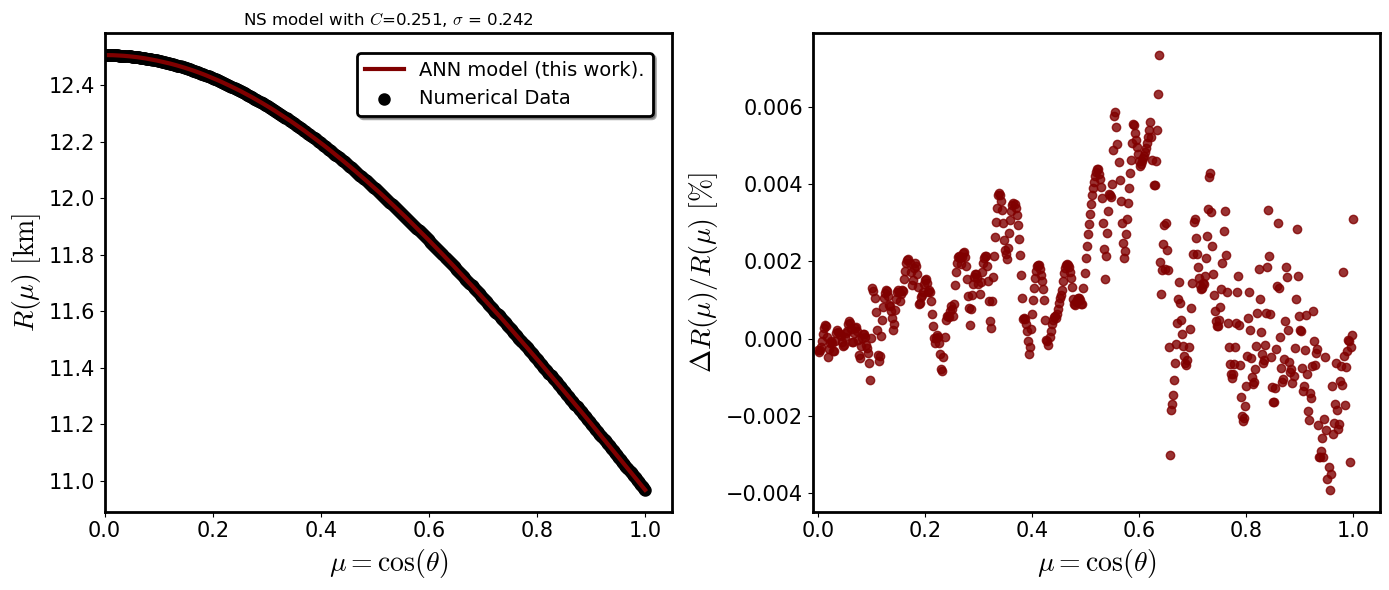

KeyboardInterrupt: 

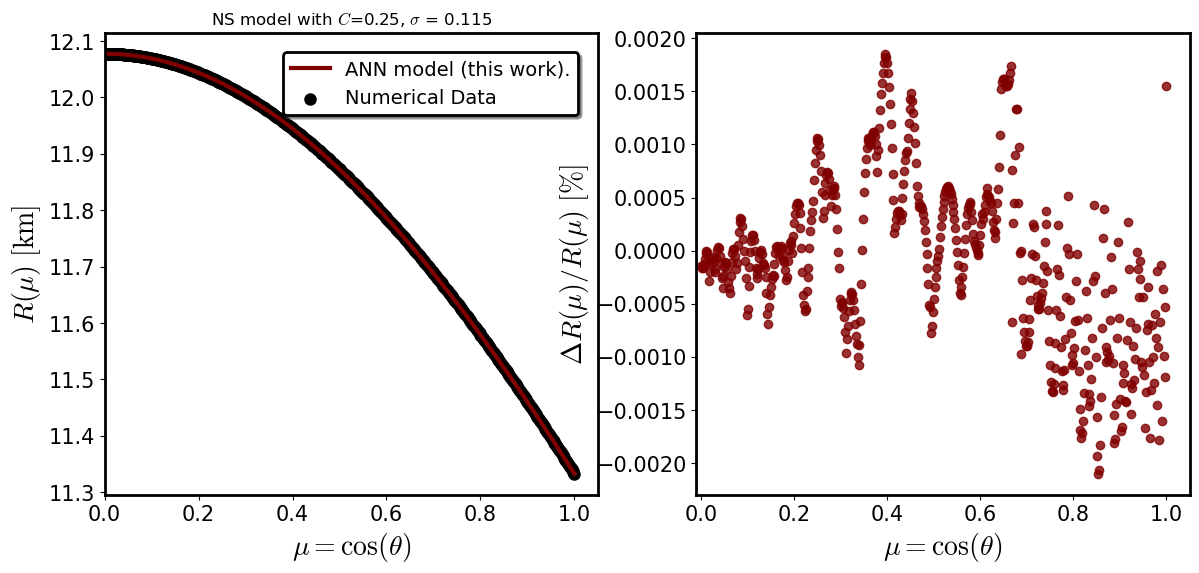

In [28]:
# Select Training or test set
is_train = False # True or False

select_set = lambda is_train, df_train, df_test: df_train if is_train else df_test
select_features = lambda is_train, np_features_tr, np_features_ts: np_features_tr if is_train else np_features_ts
select_targets = lambda is_train, np_targets_tr, np_targets_ts: np_targets_tr if is_train else np_targets_ts
    
# Select Set (Train/Test)
df_set = select_set(is_train, df_train, df_test)
features = select_features(is_train, np_features_tr, np_features_ts)
targets = select_targets(is_train, np_targets_tr, np_targets_ts)
    
for star_index in range(0, 150):
    # Do not change
    low = star_index * N_MU
    high = (star_index + 1) * N_MU
    mu = df_set['cos(theta)'].iloc[low:high]
    
    
    # Transformed estimations and targets to kilometers 
    estimation = regressor.predict(features[low:high])
    ##########################################################################
    #Convert the estimation list to 1-d array with dtype float 64 in order 
    #to have the same dimenensions and dtype with mu = cos(theta)
    estimation = estimation.ravel().astype(np.float64) 
    ##########################################################################
    maxmin_diff = df_set['Req_num'].iloc[low] - df_set['Rpole_num'].iloc[low]
    min_ = df_set['Rpole_num'].iloc[low]
    
    # Using the universal relations provided:
    #maxmin_diff = df_set['Req_num'].iloc[low] -  R_pole(df_set['Req_num'].iloc[low], C, sigma)
    #min_ = R_pole(df_set['Req_num'].iloc[low], C, sigma)
   
    
    # Static case
    if np.all(df_set[spin].iloc[low:high] == 0):
        model_estimation = estimation * df_set['Req_num'].iloc[low]
        real_targets = targets[low:high] * df_set['Req_num'].iloc[low]
    # Rotational case
    else:
        model_estimation = estimation * (maxmin_diff) + min_ 
        real_targets = targets[low:high] * (maxmin_diff) + min_
    real_targets = real_targets.ravel()
    
    ANN_fract_diff = 100*(model_estimation - real_targets)/real_targets
   
    ############# Req, C and sigma for each star ######################################
    C = df_set['C'].iloc[low]
    sigma = df_set['sigma'].iloc[low]
    R_eq = df_set['Req_num'].iloc[low]
    
    # Create two subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
        
    # Plot the first graph in the left subplot
    axs[0].plot(mu, model_estimation, lw=3, c='maroon', label='ANN model (this work).')
    axs[0].scatter(mu, real_targets, lw=3, c='black', label='Numerical Data')
    
    axs[0].set_xlabel(r'$\mu = \cos(\theta)$', fontsize=20)
    axs[0].set_ylabel(r'$R(\mu) \ [\mathrm{km}]$', fontsize=20)
    axs[0].set_title(f'NS model with $C$={round(C,3)}, $\sigma$ = {round(sigma,3)}')
    axs[0].legend(loc='best', prop={'size': 15}, shadow=True, fontsize='large')
    axs[0].tick_params(axis='both', which='both', labelsize=15)

    axs[0].set_xlim(0,None)

    for axis in ['top','bottom','left','right']:
        axs[0].spines[axis].set_linewidth(2.0)

    leg = axs[0].legend(loc="best",ncol=1, borderaxespad=1, prop={'size': 14}, shadow=True, fontsize="large") 
    leg.get_frame().set_linewidth(2.0)
    leg.get_frame().set_edgecolor('black')
    

    axs[1].scatter(mu, ANN_fract_diff , lw=1, alpha = 0.8, c='maroon')
    axs[1].set_xlabel(r'$ \mu = \cos(\theta)$', fontsize=20)
    axs[1].set_ylabel(r'$\Delta R(\mu)/ R(\mu) \ [\%]$', fontsize=20)
    axs[1].tick_params(axis='both', which='both', labelsize=15)


    for axis in ['top','bottom','left','right']:
        axs[1].spines[axis].set_linewidth(2.0)

    axs[1].set_xlim(-0.01,None)

    
    plt.tight_layout()
    plt.show()

 